In [118]:
import pandas as pd
import gc
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
from pandas.api.types import is_datetime64_any_dtype
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import calendar
from typing import List, Tuple, Dict, Optional
import xgboost as xgb
from tqdm import tqdm
from matplotlib import pyplot as plt
import zipfile
from scipy.stats.mstats import winsorize
import time
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from collections import defaultdict


In [119]:
metrics_02 = pd.read_csv('metrics_bound0.02_n_estimators100_max_depth3.csv')

In [120]:
metrics_05 = pd.read_csv('metrics_bound0.02_n_estimators100_max_depth3.csv')

### Track R_squared and MSE

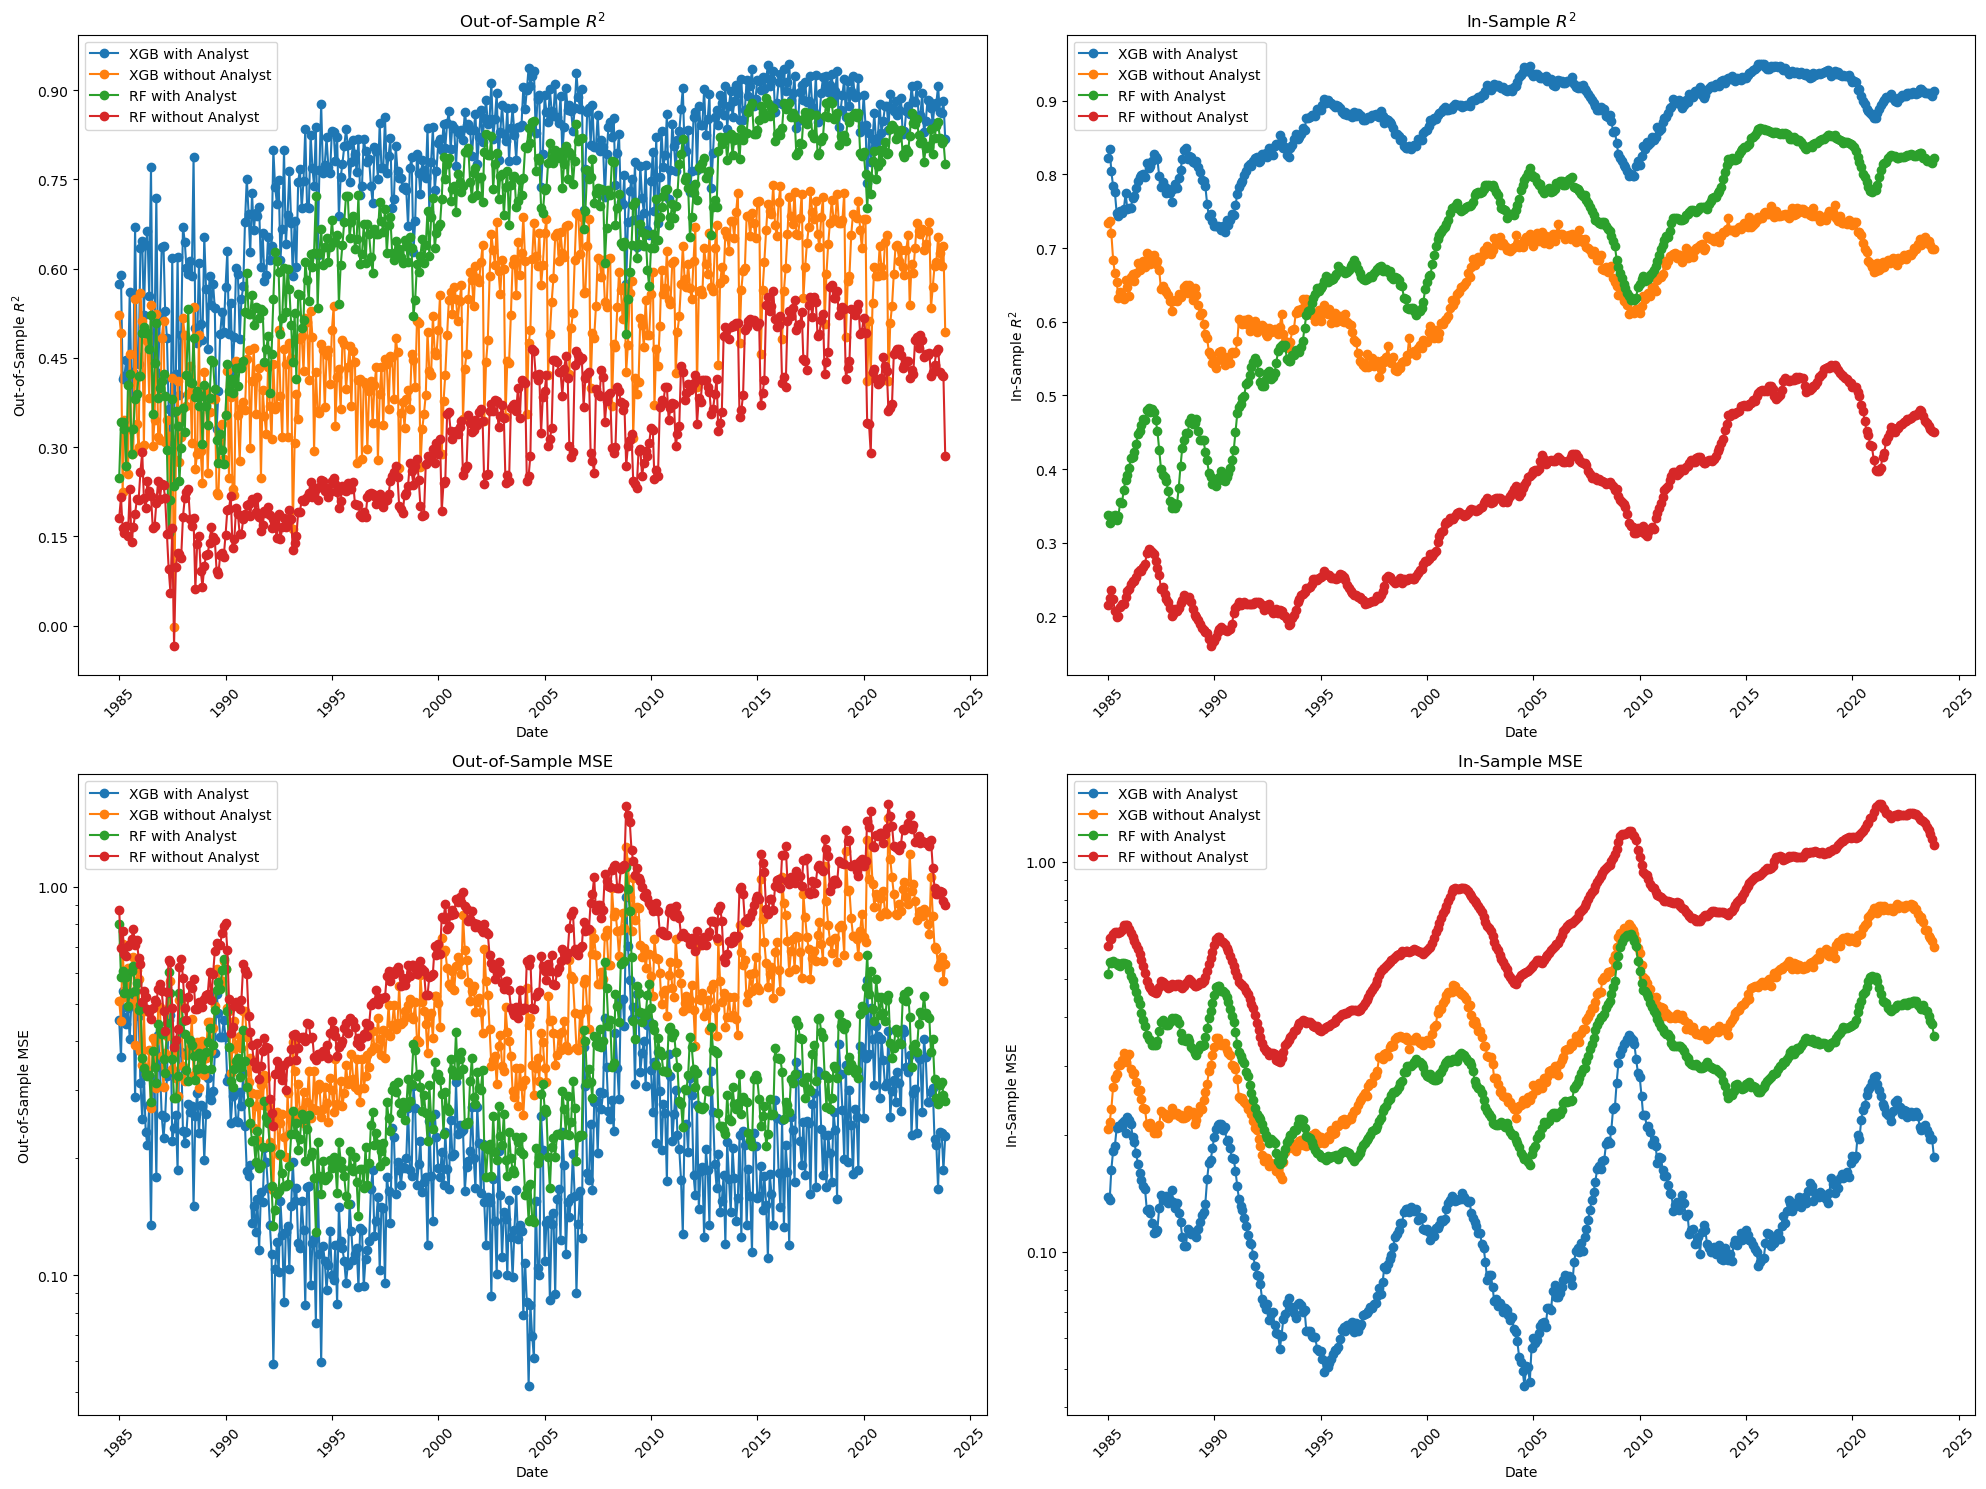

Plot saved as: output_plots/performance_metrics_over_time.png


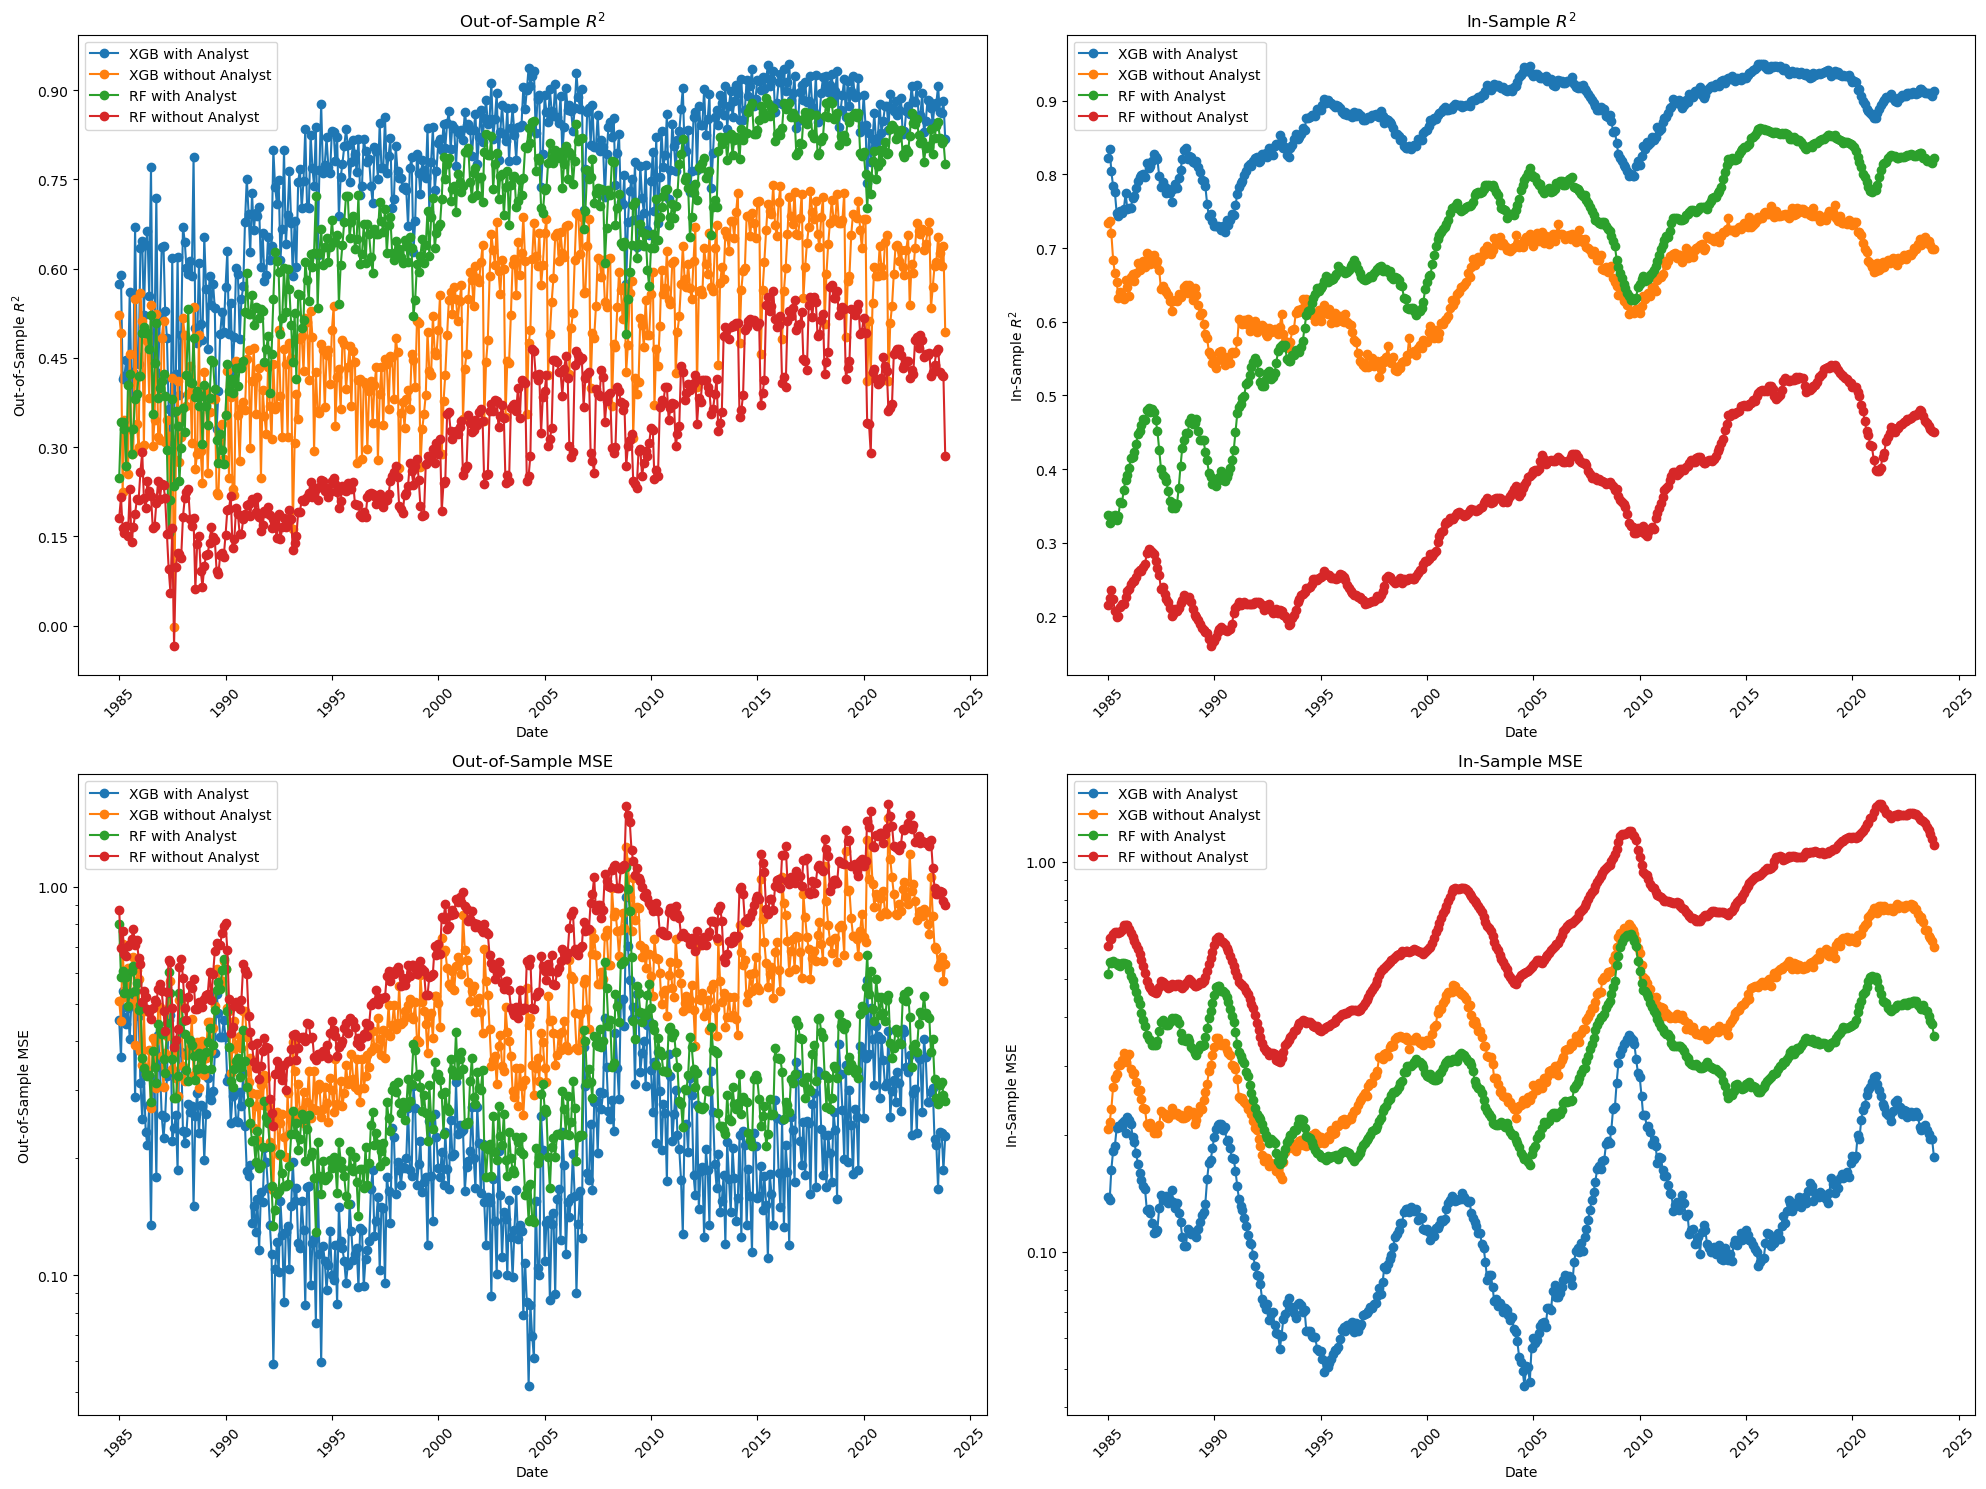

Plot saved as: output_plots/performance_metrics_over_time_5.png


In [121]:
def plot_performance_metrics(df, output_filename="performance_metrics.png"):
    # Prepare the DataFrame by ensuring 'date' is a datetime type
    df['date'] = pd.to_datetime(df['date'])

    # Set up the plotting area
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))  # Increased size for clarity
    axes = axes.flatten()

    # Titles and metrics to plot
    titles = ['Out-of-Sample $R^2$', 'In-Sample $R^2$', 'Out-of-Sample MSE', 'In-Sample MSE']
    metrics = ['test_r2', 'train_r2', 'test_mse', 'train_mse']

    # Loop through each metric to create a subplot
    for i, metric in enumerate(metrics):
        # Filter data for each combination and plot
        for model_type in ['xgb', 'rf']:
            for with_analyst in ['yes', 'no']:
                label = f"{model_type.upper()} {'with' if with_analyst == 'yes' else 'without'} Analyst"
                subset = df[(df['model_type'] == model_type) & (df['with_analyst'] == with_analyst)]
                subset = subset.sort_values('date')
                axes[i].plot(subset['date'], subset[metric], label=label, marker='o', linestyle='-')

        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel(titles[i])

        # Enhance y-axis label readability
        axes[i].yaxis.set_major_locator(ticker.MaxNLocator(10))  # Dynamically set the number of ticks
        if 'mse' in metric:
            axes[i].set_yscale('log')  # Use logarithmic scale for MSE to handle wide ranges
            axes[i].yaxis.set_major_formatter(ticker.ScalarFormatter())  # Use scalar formatter for log scale

        # Rotate labels if needed
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(45)

        axes[i].legend()

    plt.tight_layout()
    plt.savefig(output_filename)  # Save the figure to a file
    plt.show()
    print(f"Plot saved as: {output_filename}")

# Example usage
plot_performance_metrics(metrics_02, "output_plots/performance_metrics_over_time.png")
plot_performance_metrics(metrics_05, "output_plots/performance_metrics_over_time_5.png")

### Track Feature Importance Overtime

#### Feature Importance Overtime by F Measure

In [122]:
metrics_02.columns

Index(['Unnamed: 0', 'date', 'model_type', 'with_analyst', 'train_r2',
       'test_r2', 'train_mse', 'test_mse', 'feature_importances',
       'feature_dict_RSquared', 'Earning_Surprise_Model',
       'Earning_Surprise_Analyst', 'Earning_Model_VS_Analyst',
       'median_earning_surprise', 'std_earning_surprise',
       'top_earning_surprises'],
      dtype='object')

In [123]:
metrics_02['feature_dict_RSquared']


0       [('EST_1QTR_MEAN_EPS', 24.829560935920373), ('...
1       [('PEG_trailing', 0.9567089441664967), ('rect_...
2       [('EST_1QTR_MEAN_EPS', 20.918212338828273), ('...
3       [('npm', 0.5829257083623726), ('opmad', 0.3248...
4       [('EST_1QTR_MEAN_EPS', 29.75077373383012), ('r...
                              ...                        
1863    [('opmad', 0.5379292846691422), ('roce', 0.083...
1864    [('EST_1QTR_MEAN_EPS', 23.674467678056953), ('...
1865    [('ptpm', 1.239206779341612), ('cash_debt', 0....
1866    [('EST_1QTR_MEAN_EPS', 21.688896400350053), ('...
1867    [('opmad', 1.0485352690746408), ('pretret_earn...
Name: feature_dict_RSquared, Length: 1868, dtype: object

In [124]:
def get_feature_importances_by_configuration(df):
    # Initialize a dictionary to store DataFrames for each configuration
    configurations = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    # Process each row in the DataFrame
    for _, row in df.iterrows():
        date = row['date']
        model_type = row['model_type']
        with_analyst = row['with_analyst']
        
        my_dict = eval(row['feature_importances'])
        
        total_importance = sum(my_dict.values())

        for feature, importance in my_dict.items():
            if total_importance > 0:  # Avoid division by zero
                configurations[(model_type, with_analyst)][date][feature] += importance

    # Normalize the importances and convert to DataFrame
    result_dfs = {}
    for config, data in configurations.items():
        # Create DataFrame from the nested dictionary
        temp_df = pd.DataFrame.from_dict(data, orient='index').fillna(0)
        # Normalize the importances to sum to 100% per row
        temp_df = temp_df.div(temp_df.sum(axis=1), axis=0) * 100
        result_dfs[config] = temp_df

    return result_dfs

# Example usage, assuming `metrics_df` is your DataFrame
config_dfs_2 = get_feature_importances_by_configuration(metrics_02)
config_dfs_5 = get_feature_importances_by_configuration(metrics_02)


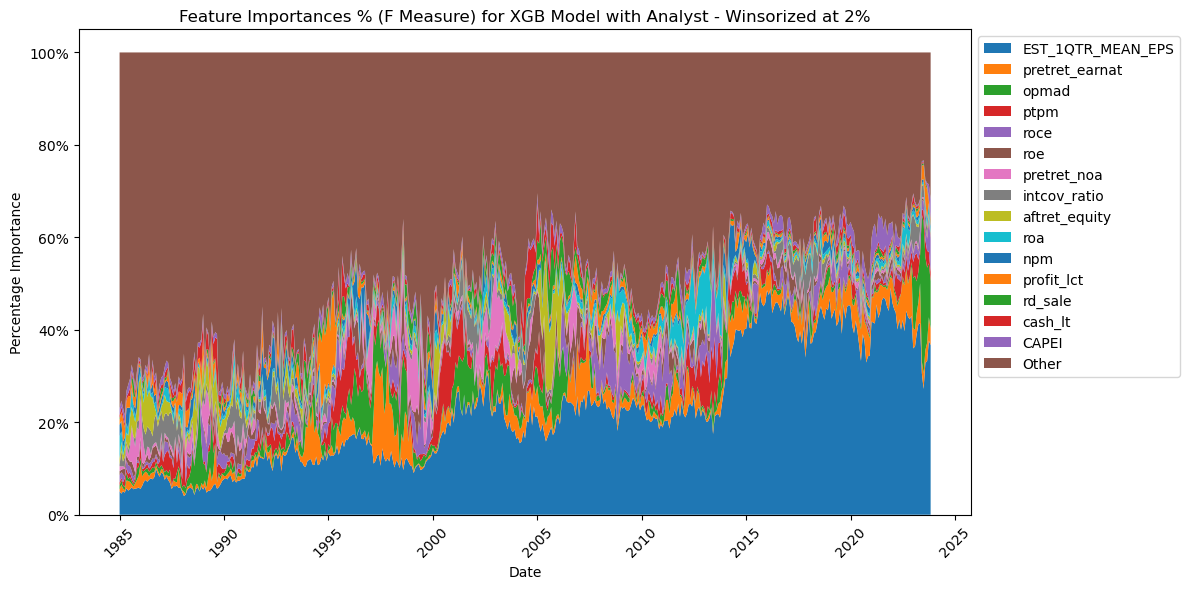

Plot saved as Feature_Importances_perc_(F_Measure)_for_XGB_Model_with_Analyst_-_Winsorized_at_2perc.png


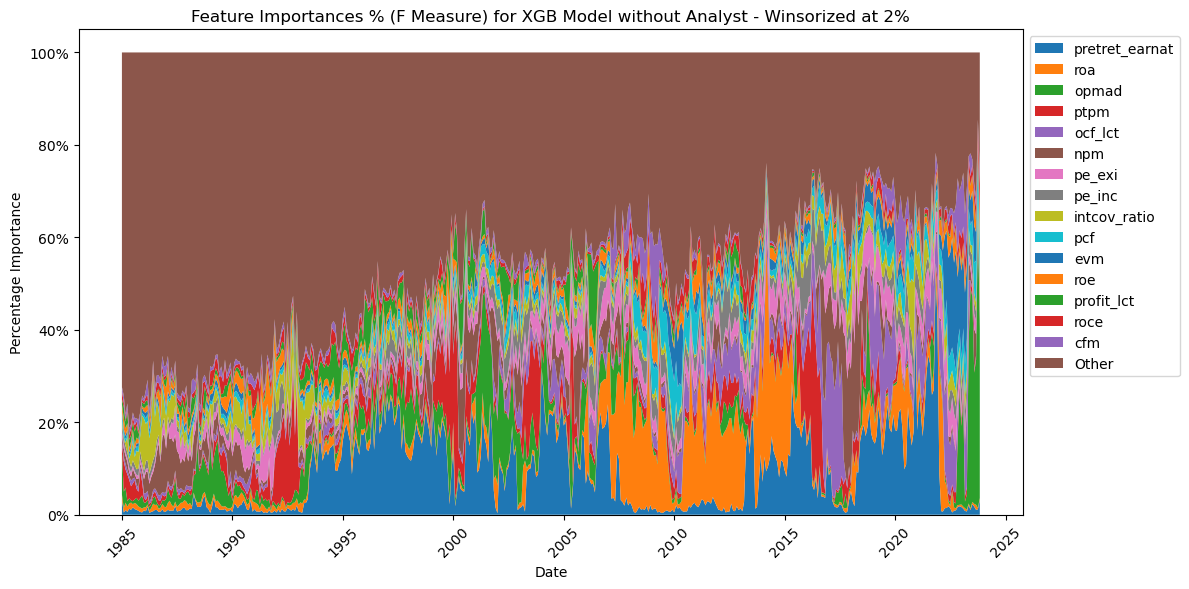

Plot saved as Feature_Importances_perc_(F_Measure)_for_XGB_Model_without_Analyst_-_Winsorized_at_2perc.png


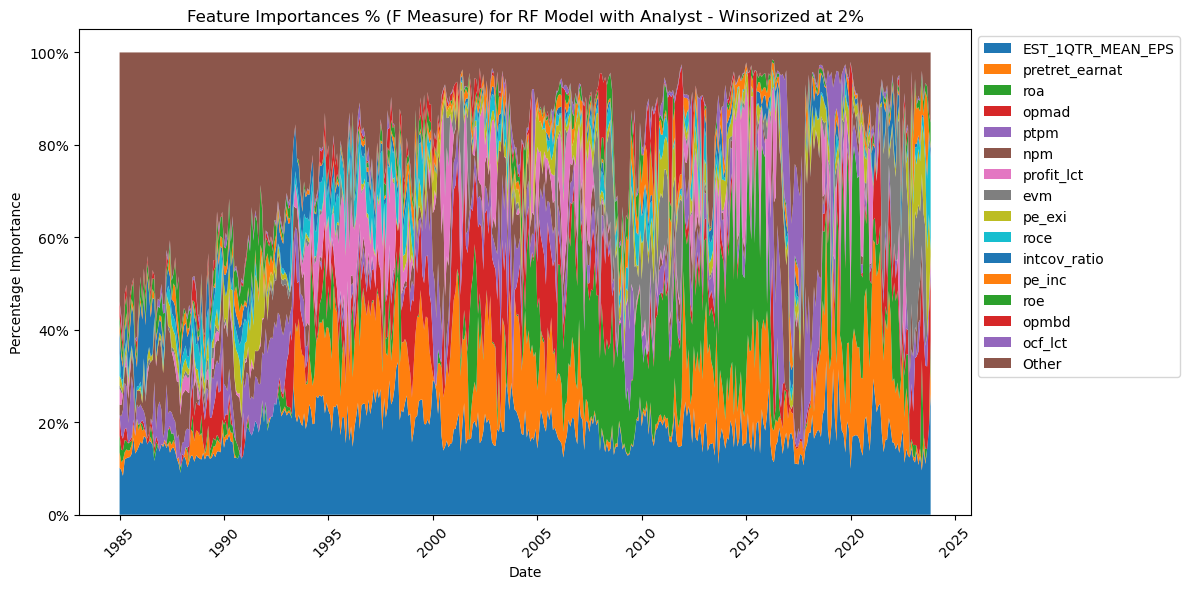

Plot saved as Feature_Importances_perc_(F_Measure)_for_RF_Model_with_Analyst_-_Winsorized_at_2perc.png


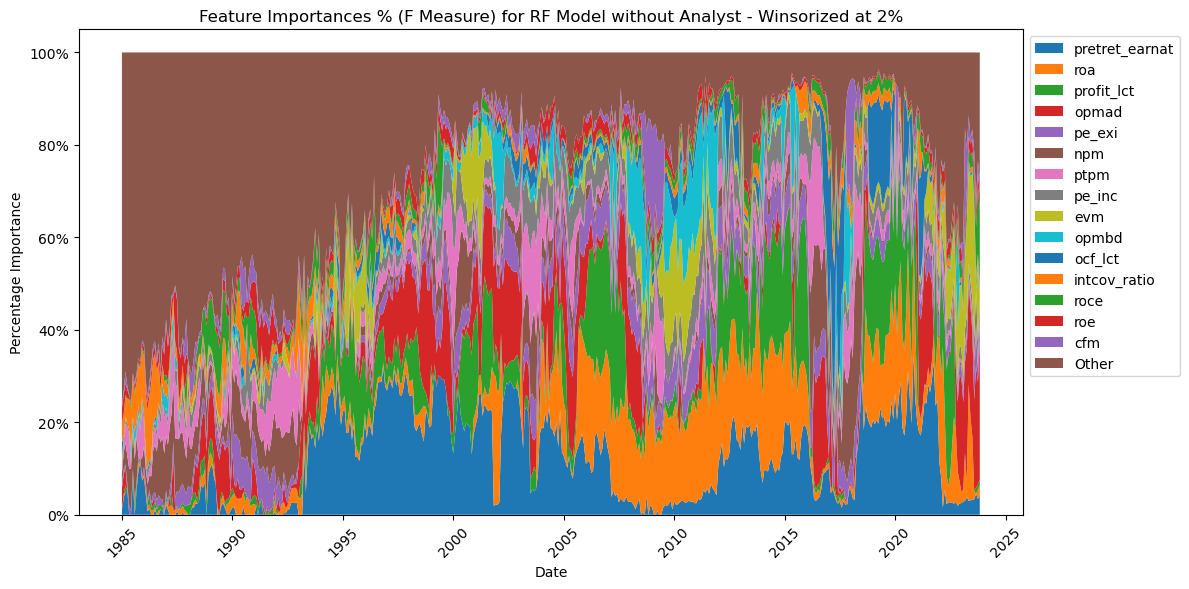

Plot saved as Feature_Importances_perc_(F_Measure)_for_RF_Model_without_Analyst_-_Winsorized_at_2perc.png


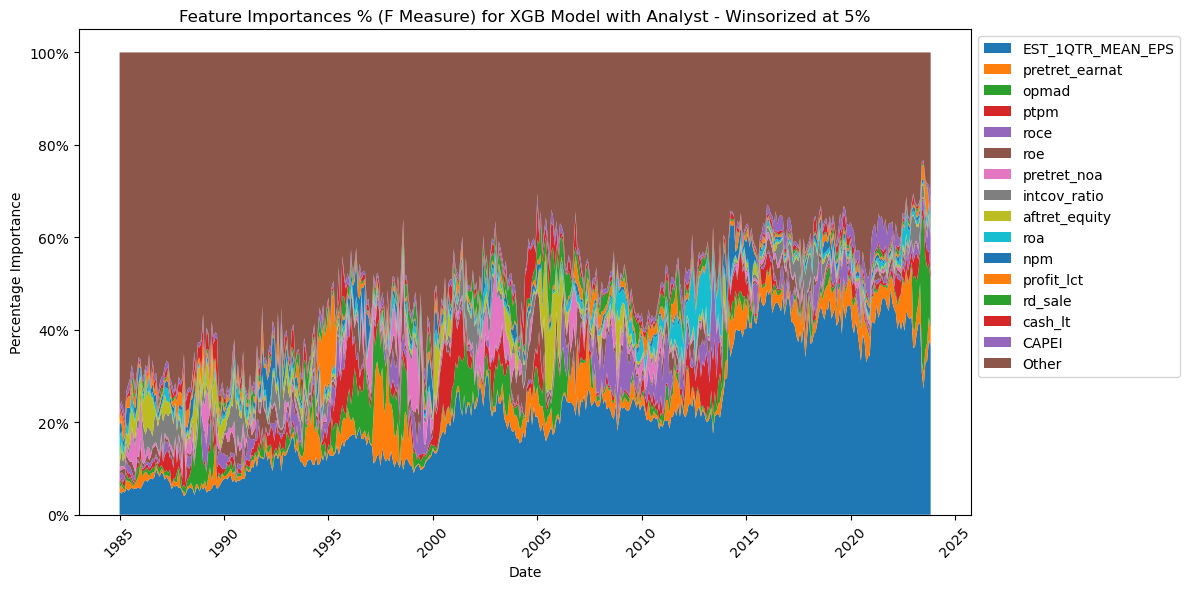

Plot saved as Feature_Importances_perc_(F_Measure)_for_XGB_Model_with_Analyst_-_Winsorized_at_5perc.png


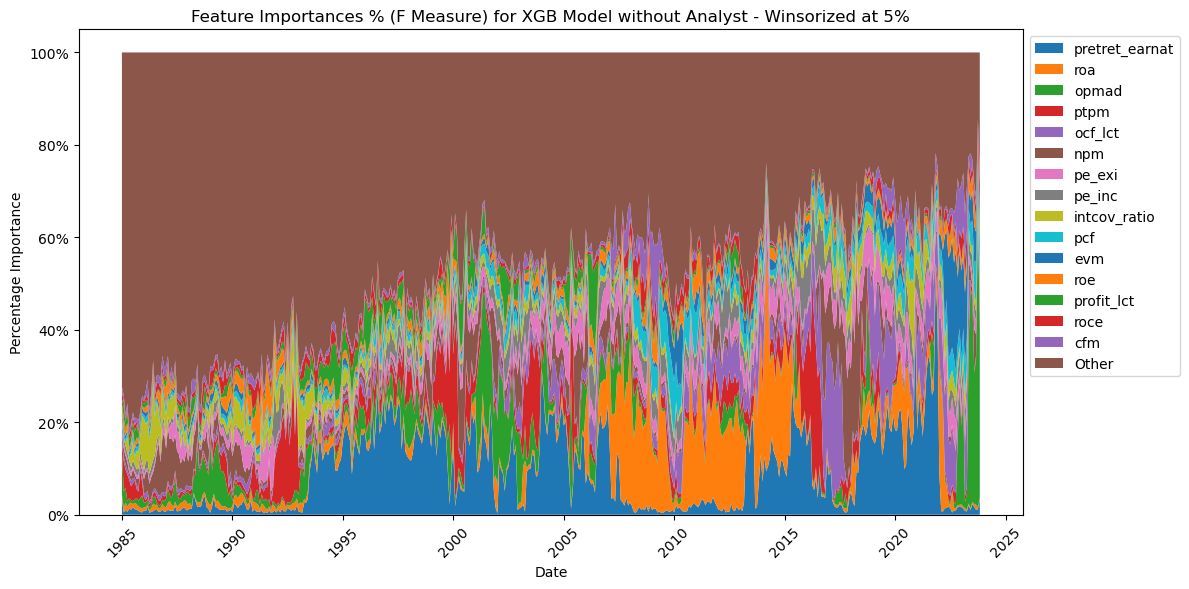

Plot saved as Feature_Importances_perc_(F_Measure)_for_XGB_Model_without_Analyst_-_Winsorized_at_5perc.png


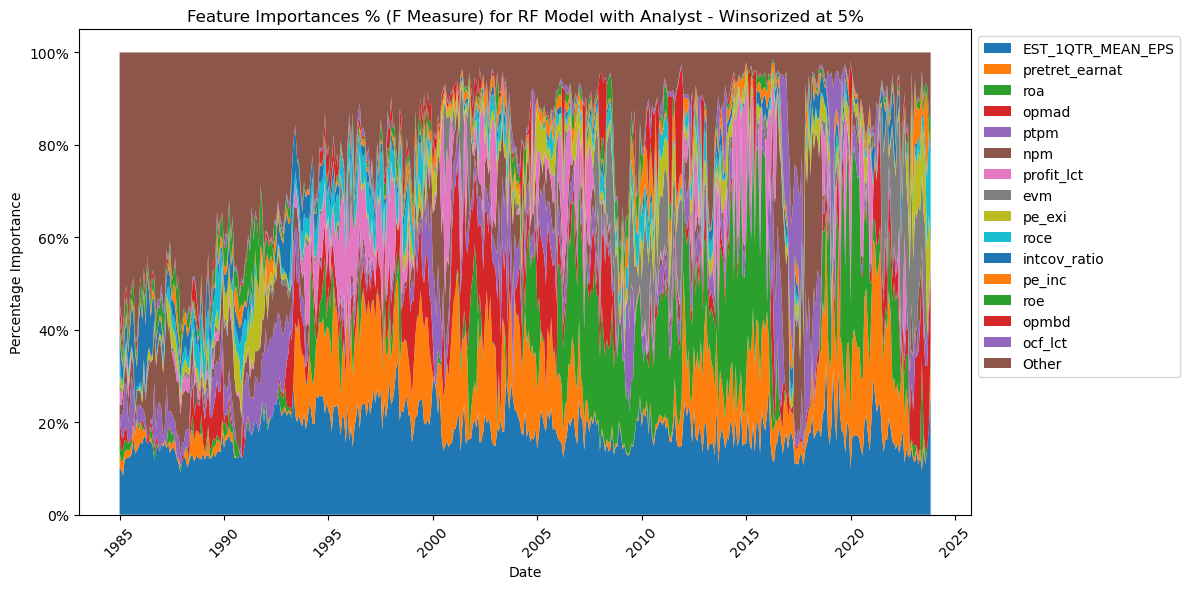

Plot saved as Feature_Importances_perc_(F_Measure)_for_RF_Model_with_Analyst_-_Winsorized_at_5perc.png


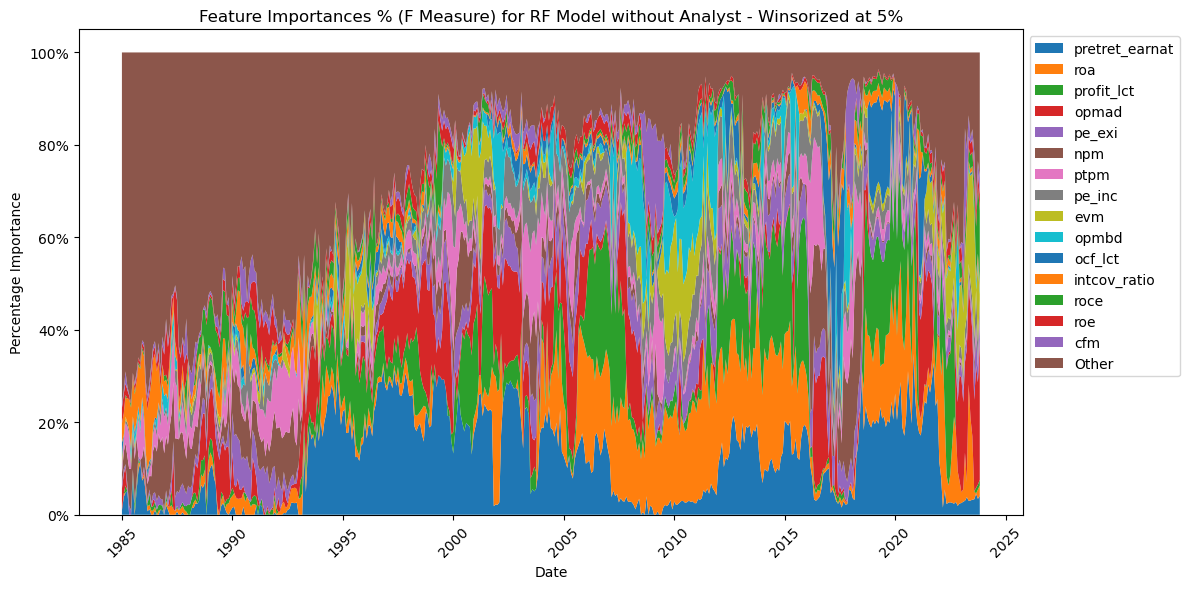

Plot saved as Feature_Importances_perc_(F_Measure)_for_RF_Model_without_Analyst_-_Winsorized_at_5perc.png


In [125]:
def plot_configurations(config_dfs, output_dir='output_plots', winsorize=None):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create a plot for each configuration
    for (model_type, with_analyst), df in config_dfs.items():
        plt.figure(figsize=(12, 6))

        # Calculate the mean importance over time for each feature
        mean_importances = df.mean(axis=0)
        # Sort features by their average importance and keep only the top 15
        top_features = mean_importances.sort_values(ascending=False).head(15).index.tolist()
        # Identify features not in the top 15 to group as 'Other'
        other_features = [feature for feature in df.columns if feature not in top_features]

        # Aggregate other features into a single series
        if other_features:
            df['Other'] = df[other_features].sum(axis=1)
            df.drop(columns=other_features, inplace=True)

        # Reorder dataframe to plot top 1 feature, next 14 features, then 'Other'
        ordered_features = [top_features[0]] + top_features[1:15] + ['Other'] if 'Other' in df.columns else top_features[0:15]

        # Only keep features with a maximum percentage over a certain threshold (e.g., 2%)
        df = df.loc[:, df.max() > 2]

        # Stack plot with labels for ordered features
        plt.stackplot(df.index, [df[feature] for feature in ordered_features if feature in df.columns], labels=[feature for feature in ordered_features if feature in df.columns])
        winz_title = f" - Winsorized at {winsorize}" if winsorize else ""
        title = f'Feature Importances % (F Measure) for {model_type.upper()} Model {"with" if with_analyst == "yes" else "without"} Analyst{winz_title}'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Percentage Importance')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y / 100)))  # Adjust based on how data is scaled
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Generate filename from title
        filename = f"{title.replace(' ', '_').replace('%', 'perc')}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        plt.show()
        print(f"Plot saved as {filename}")

# Example usage, ensure that config_d
plot_configurations(config_dfs_2, winsorize='2%')
plot_configurations(config_dfs_5, winsorize='5%')

In [126]:
# Example usage, assuming `metrics_df` is your DataFrame
config_dfs_2 = get_feature_importances_by_configuration(metrics_02)
config_dfs_5 = get_feature_importances_by_configuration(metrics_02)

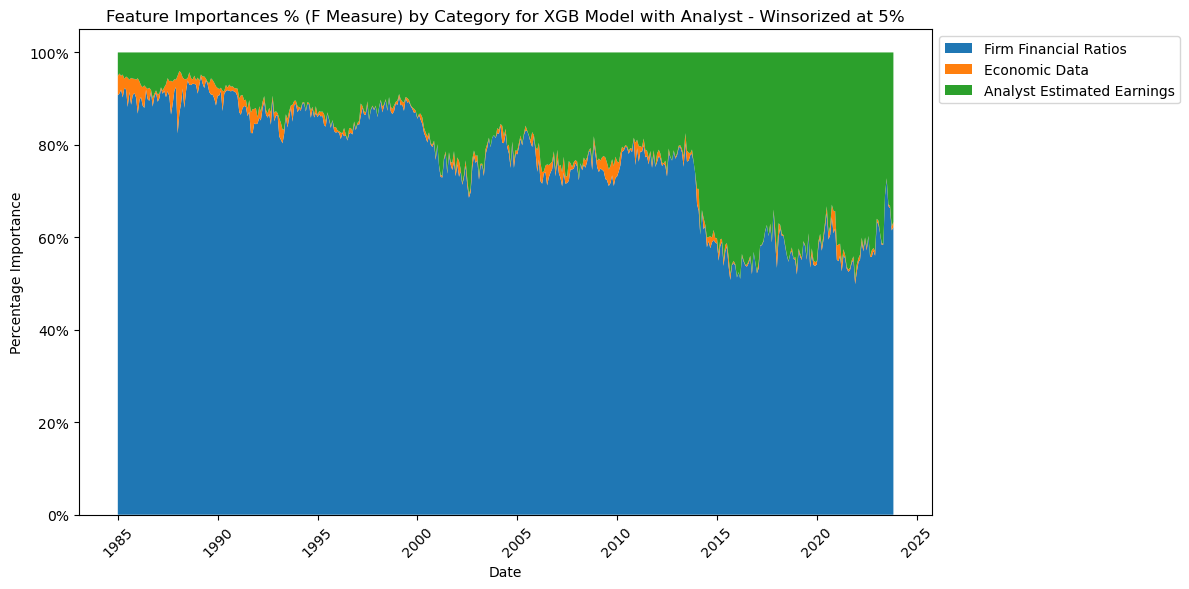

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_XGB_Model_with_Analyst_-_Winsorized_at_5perc.png


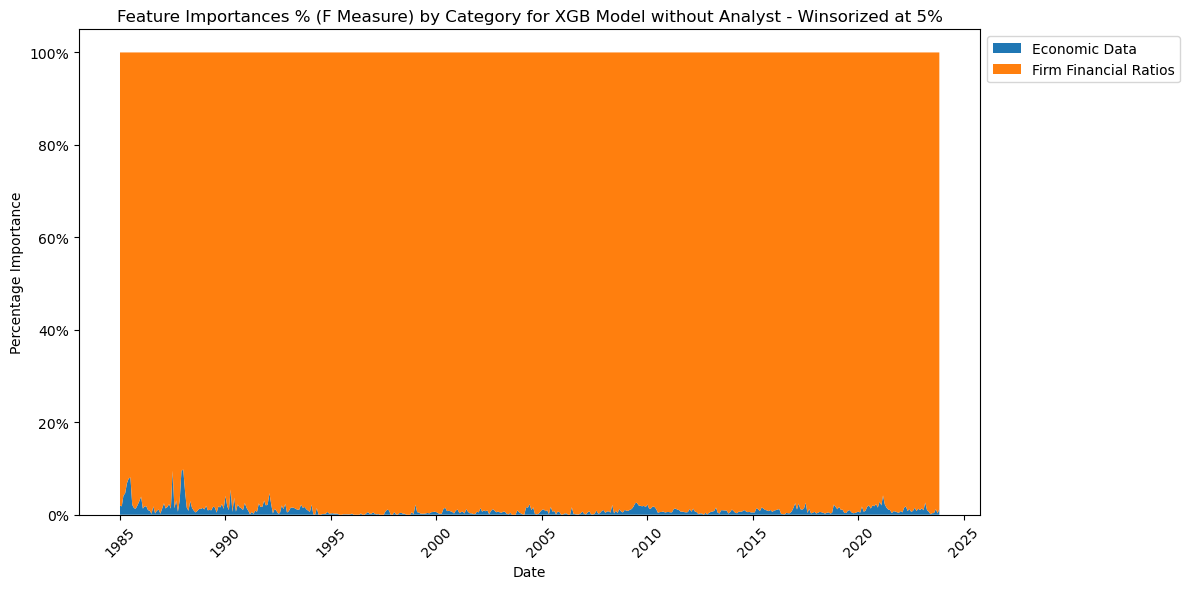

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_XGB_Model_without_Analyst_-_Winsorized_at_5perc.png


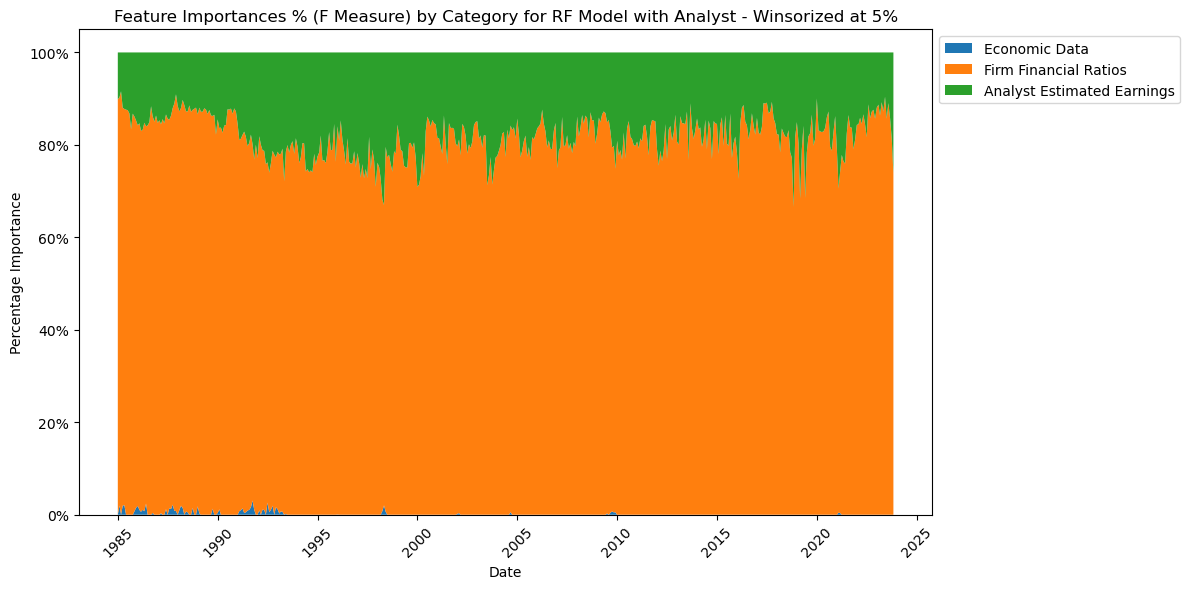

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_RF_Model_with_Analyst_-_Winsorized_at_5perc.png


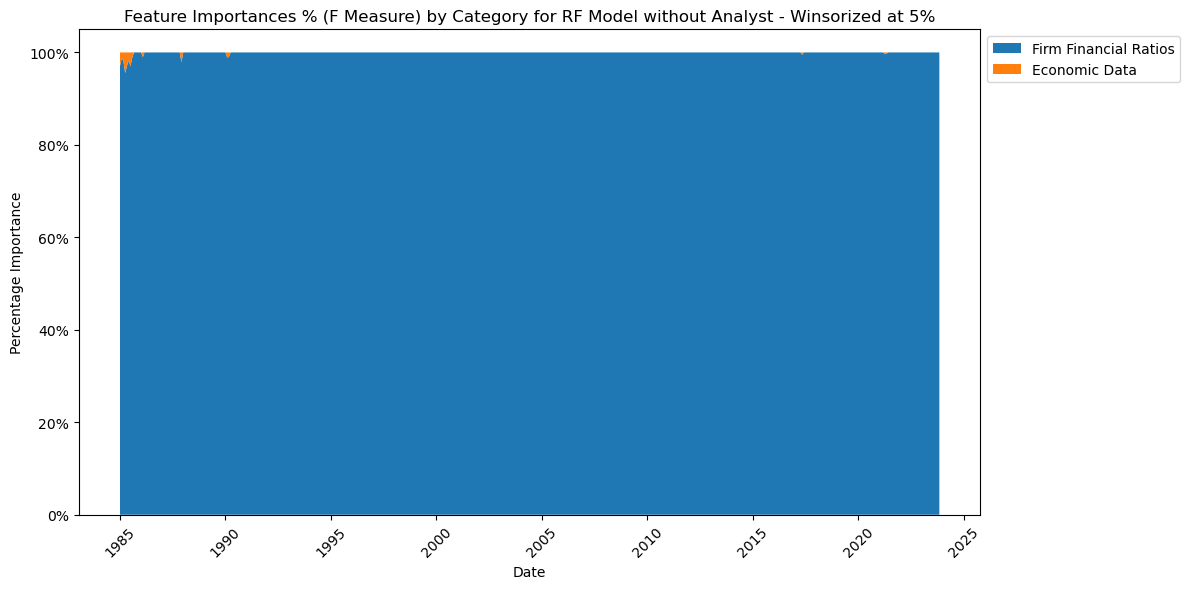

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_RF_Model_without_Analyst_-_Winsorized_at_5perc.png


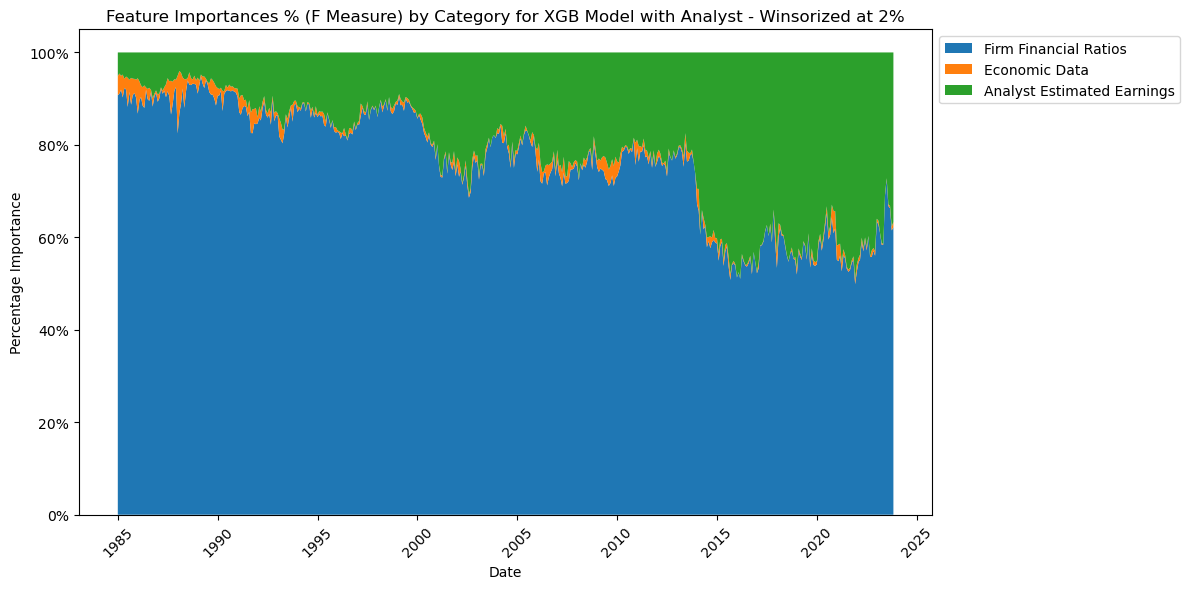

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_XGB_Model_with_Analyst_-_Winsorized_at_2perc.png


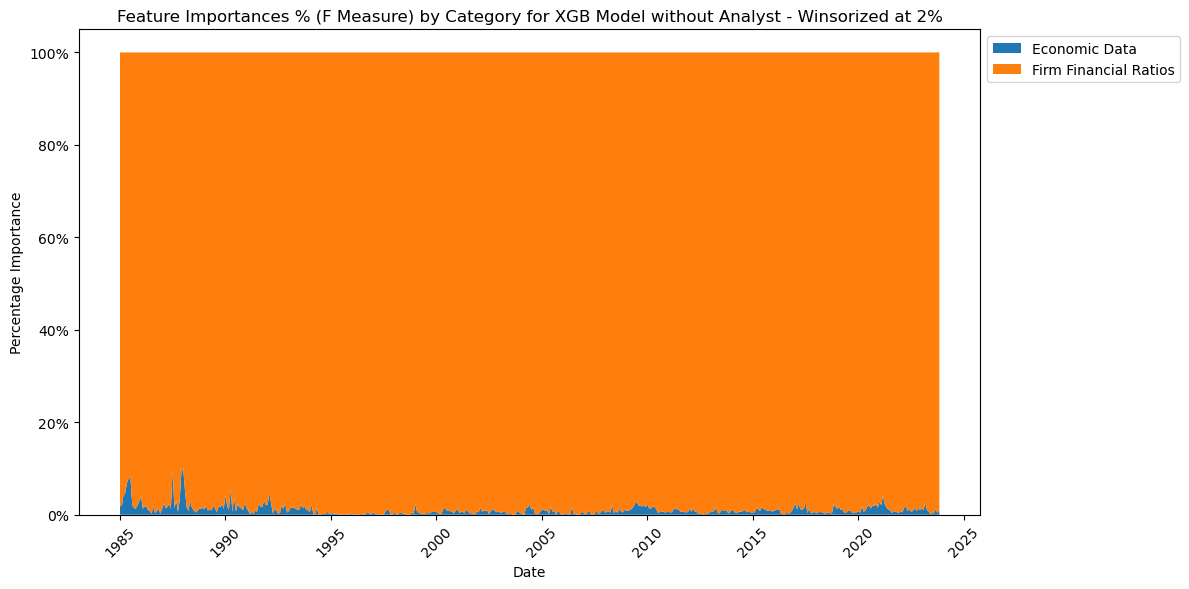

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_XGB_Model_without_Analyst_-_Winsorized_at_2perc.png


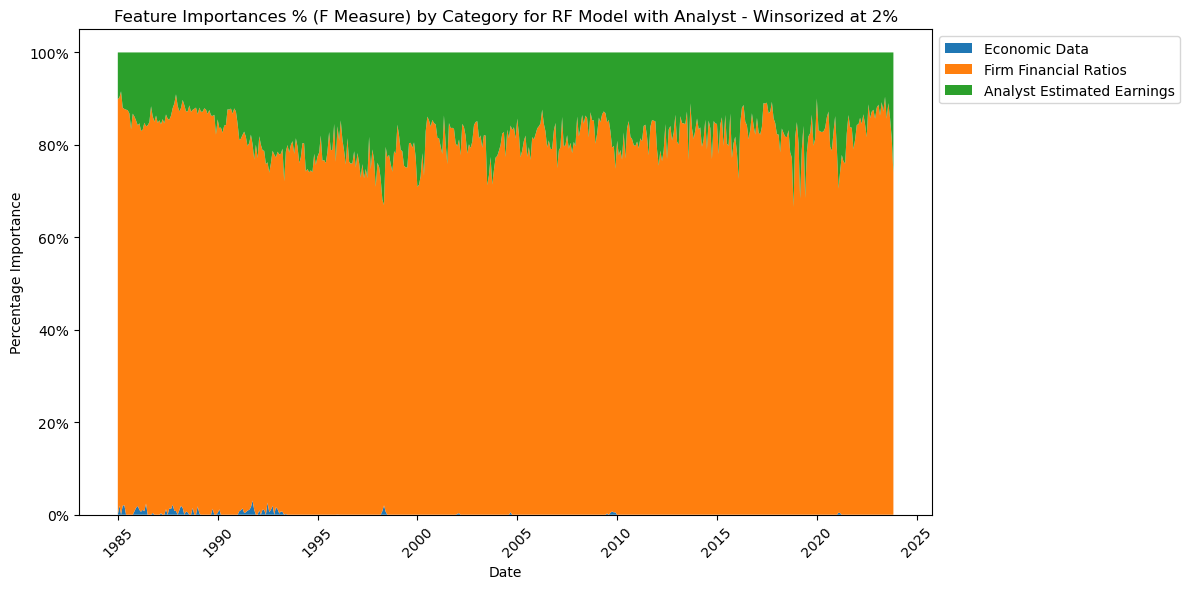

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_RF_Model_with_Analyst_-_Winsorized_at_2perc.png


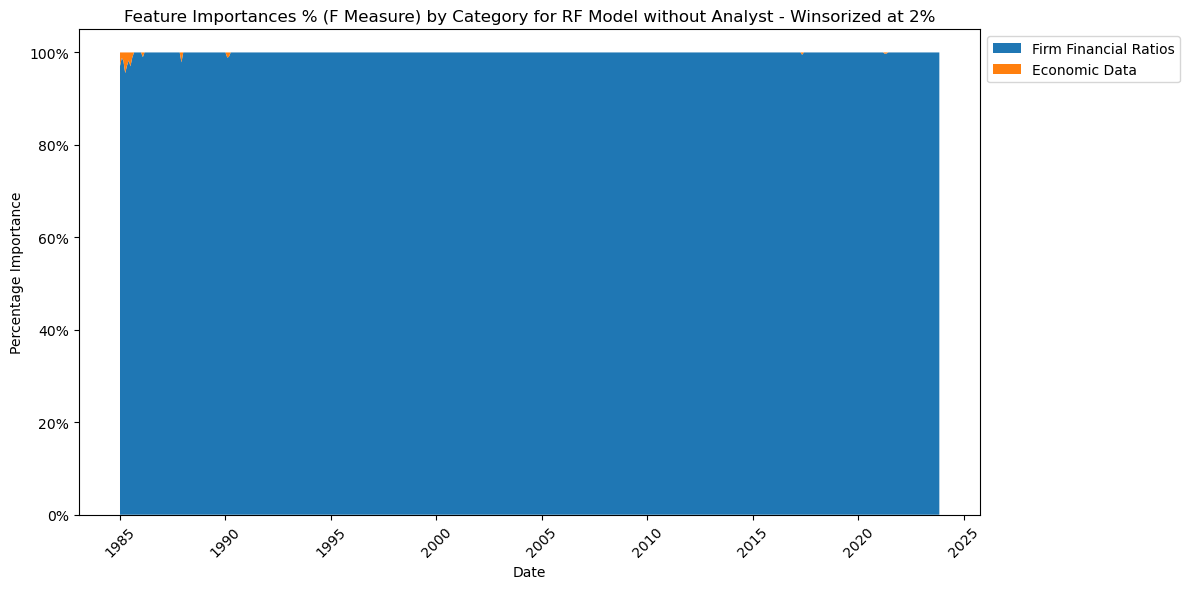

Plot saved as Feature_Importances_perc_(F_Measure)_by_Category_for_RF_Model_without_Analyst_-_Winsorized_at_2perc.png


In [127]:
def plot_configurations(config_dfs, output_dir='output_plots', winsorize=None):
    # Define the group mappings
    group_mappings = {
        'log_diff_ROUTPUT': 'Economic Data',
        'log_diff_RCON': 'Economic Data',
        'log_diff_IPT': 'Economic Data',
        'UNEMPLOYMENT': 'Economic Data',
        'EST_1QTR_MEAN_EPS': 'Analyst Estimated Earnings',
    }

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create a plot for each configuration
    for (model_type, with_analyst), df in config_dfs.items():
        plt.figure(figsize=(12, 6))

        # Initialize a DataFrame for grouped data
        grouped_df = pd.DataFrame(index=df.index)

        # Aggregate features according to the group mappings
        for feature in df.columns:
            group_name = group_mappings.get(feature, 'Firm Financial Ratios')
            if group_name not in grouped_df:
                grouped_df[group_name] = df[feature]
            else:
                grouped_df[group_name] += df[feature]

        # Only keep groups with a maximum percentage over a certain threshold (e.g., 2%)
        grouped_df = grouped_df.loc[:, grouped_df.max() > 2]

        # Plotting the stack plot
        plt.stackplot(grouped_df.index, [grouped_df[group] for group in grouped_df.columns], labels=grouped_df.columns)

        # Construct the title to include Winsorization if specified
        winz_title = f" - Winsorized at {winsorize}" if winsorize else ""
        title = f'Feature Importances % (F Measure) by Category for {model_type.upper()} Model {"with" if with_analyst == "yes" else "without"} Analyst{winz_title}'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Percentage Importance')
        # Format y-axis as percentages
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/100)))
        
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Generate filename from title, include Winsorization info
        filename = f"{title.replace(' ', '_').replace('%', 'perc')}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        plt.show()
        print(f"Plot saved as {filename}")

# Example usage, make sure config_dfs is correctly defined:
plot_configurations(config_dfs_5, winsorize='5%')
plot_configurations(config_dfs_2, winsorize='2%')


In [128]:
def calculate_top_features_over_time(config_dfs):
    # Initialize a DataFrame to aggregate features from all configurations
    aggregated_df = pd.DataFrame()
    
    # Aggregate all features across configurations
    for key, df in config_dfs.items():
        aggregated_df = pd.concat([aggregated_df, df], axis=0)

    # Calculate overall top features
    overall_mean = aggregated_df.mean().sort_values(ascending=False).head(15)
    
    # Define financial crises periods including the 2020 COVID-19 recession
    crises_periods = [
        ('1987-10-01', '1987-12-31'),  # Black Monday 1987
        ('2000-01-01', '2002-12-31'),  # Early 2000s Recession
        ('2007-01-01', '2009-12-31'),  # Global Financial Crisis
        ('2020-02-01', '2020-12-31')   # COVID-19 Recession
    ]
    
    # Filter data for crises and calculate means
    crises_dfs = []
    for start, end in crises_periods:
        filtered_df = aggregated_df.loc[start:end]
        crises_dfs.append(filtered_df)
    
    crises_df = pd.concat(crises_dfs)
    crises_mean = crises_df.mean().sort_values(ascending=False).head(15)
    
    return overall_mean, crises_mean



overall_mean_5, crises_mean_5 = calculate_top_features_over_time(config_dfs_5)


overall_mean_2, crises_mean_2 = calculate_top_features_over_time(config_dfs_2)



In [129]:
display(overall_mean_5)
display(crises_mean_5)

EST_1QTR_MEAN_EPS    20.251656
pretret_earnat        8.692678
roa                   6.485827
opmad                 5.106330
ptpm                  4.290915
profit_lct            4.108474
npm                   3.894392
pe_exi                3.065851
pe_inc                2.617327
evm                   2.437032
ocf_lct               2.367958
intcov_ratio          2.302413
roce                  2.241527
roe                   1.974781
opmbd                 1.816597
dtype: float64

EST_1QTR_MEAN_EPS    20.888349
roa                   9.830702
pretret_earnat        8.689864
opmad                 6.452653
profit_lct            5.172761
ptpm                  4.115050
npm                   3.541476
evm                   3.182200
pe_inc                3.161797
pe_exi                3.158280
cfm                   2.914384
opmbd                 2.412973
roce                  2.023418
roe                   1.680929
pcf                   1.519099
dtype: float64

In [140]:
# Assuming calculate_top_features_over_time returns two Series, each containing feature importances
overall_mean_5, crises_mean_5 = calculate_top_features_over_time(config_dfs_5)
overall_mean_2, crises_mean_2 = calculate_top_features_over_time(config_dfs_2)

# Convert Series to DataFrames with a clear label for merging
df_overall_mean_5 = overall_mean_5.reset_index()
df_overall_mean_5.columns = ['Feature', 'Overall_Importance_5']

df_crises_mean_5 = crises_mean_5.reset_index()
df_crises_mean_5.columns = ['Feature', 'Crises_Importance_5']

df_overall_mean_2 = overall_mean_2.reset_index()
df_overall_mean_2.columns = ['Feature', 'Overall_Importance_2']

df_crises_mean_2 = crises_mean_2.reset_index()
df_crises_mean_2.columns = ['Feature', 'Crises_Importance_2']

# Merge all DataFrames on 'Feature'
from functools import reduce

dfs = [df_overall_mean_5, df_crises_mean_5, df_overall_mean_2, df_crises_mean_2]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Feature', how='outer'), dfs)

# Save to CSV
df_final.to_csv('top_features_by_FMeasure.csv', index=False)


In [130]:
display(overall_mean_2)
display(crises_mean_2)

EST_1QTR_MEAN_EPS    20.251656
pretret_earnat        8.692678
roa                   6.485827
opmad                 5.106330
ptpm                  4.290915
profit_lct            4.108474
npm                   3.894392
pe_exi                3.065851
pe_inc                2.617327
evm                   2.437032
ocf_lct               2.367958
intcov_ratio          2.302413
roce                  2.241527
roe                   1.974781
opmbd                 1.816597
dtype: float64

EST_1QTR_MEAN_EPS    20.888349
roa                   9.830702
pretret_earnat        8.689864
opmad                 6.452653
profit_lct            5.172761
ptpm                  4.115050
npm                   3.541476
evm                   3.182200
pe_inc                3.161797
pe_exi                3.158280
cfm                   2.914384
opmbd                 2.412973
roce                  2.023418
roe                   1.680929
pcf                   1.519099
dtype: float64

#### Feature Importance Overtime by F Measure

In [131]:
# Example usage, assuming `metrics_df` is your DataFrame
config_dfs_2 = get_feature_importances_by_configuration(metrics_02)
config_dfs_5 = get_feature_importances_by_configuration(metrics_02)


In [132]:
def get_feature_importances_rsquared_by_configuration(df):
    # Initialize a dictionary to store DataFrames for each configuration
    configurations = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

    # Process each row in the DataFrame
    for _, row in df.iterrows():
        date = row['date']
        model_type = row['model_type']
        with_analyst = row['with_analyst']
        feature_importances = eval(row['feature_dict_RSquared'])
        total_importance = sum(importance for _, importance in feature_importances)

        for feature, importance in feature_importances:
            if total_importance > 0:  # Avoid division by zero
                configurations[(model_type, with_analyst)][date][feature] += importance

    # Normalize the importances and convert to DataFrame
    result_dfs = {}
    for config, data in configurations.items():
        # Create DataFrame from the nested dictionary
        temp_df = pd.DataFrame.from_dict(data, orient='index').fillna(0)
        # Normalize the importances to sum to 100% per row
        temp_df = temp_df.div(temp_df.sum(axis=1), axis=0) * 100
        result_dfs[config] = temp_df

    return result_dfs

# Example usage, assuming `metrics_df` is your DataFrame
config_dfs_R_5 = get_feature_importances_rsquared_by_configuration(metrics_05)
config_dfs_R_2 = get_feature_importances_rsquared_by_configuration(metrics_02)


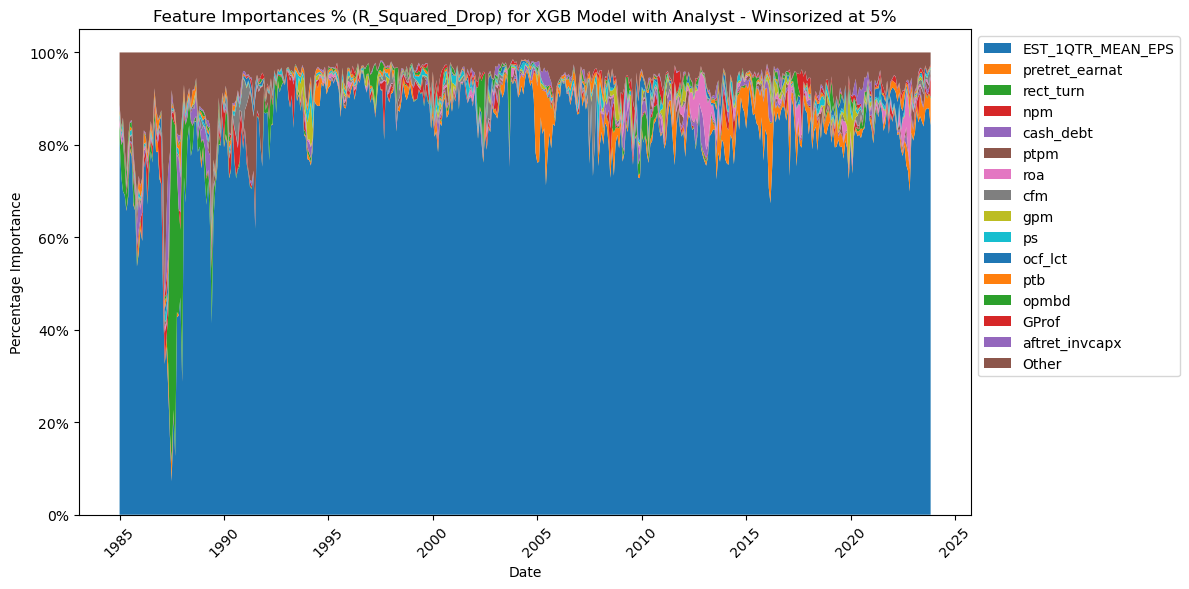

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_XGB_Model_with_Analyst_-_Winsorized_at_5perc.png


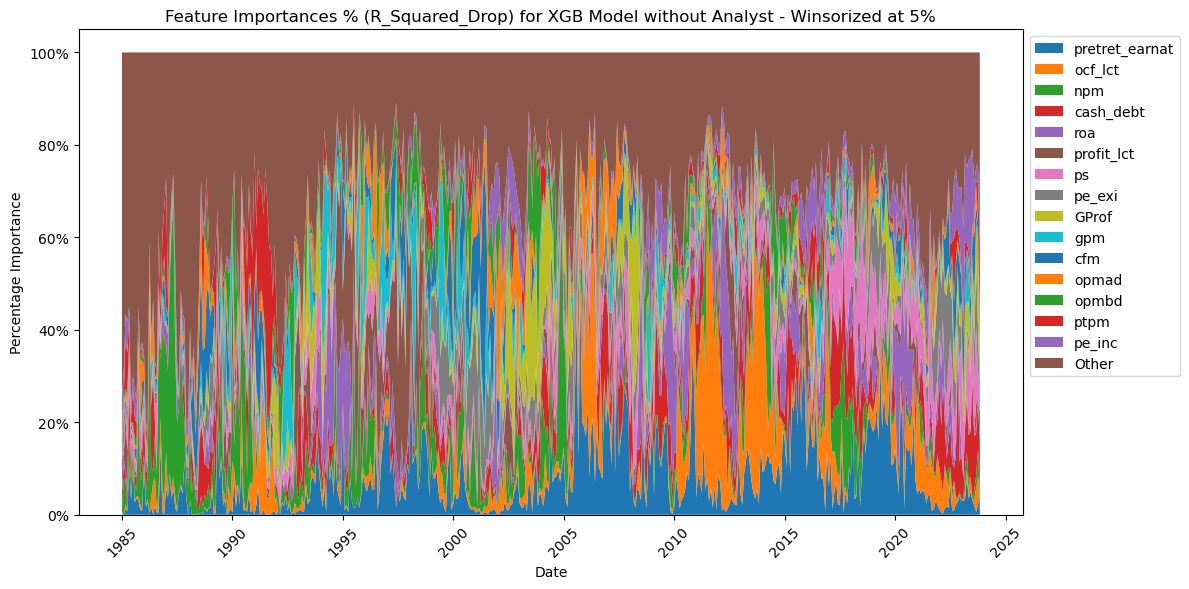

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_XGB_Model_without_Analyst_-_Winsorized_at_5perc.png


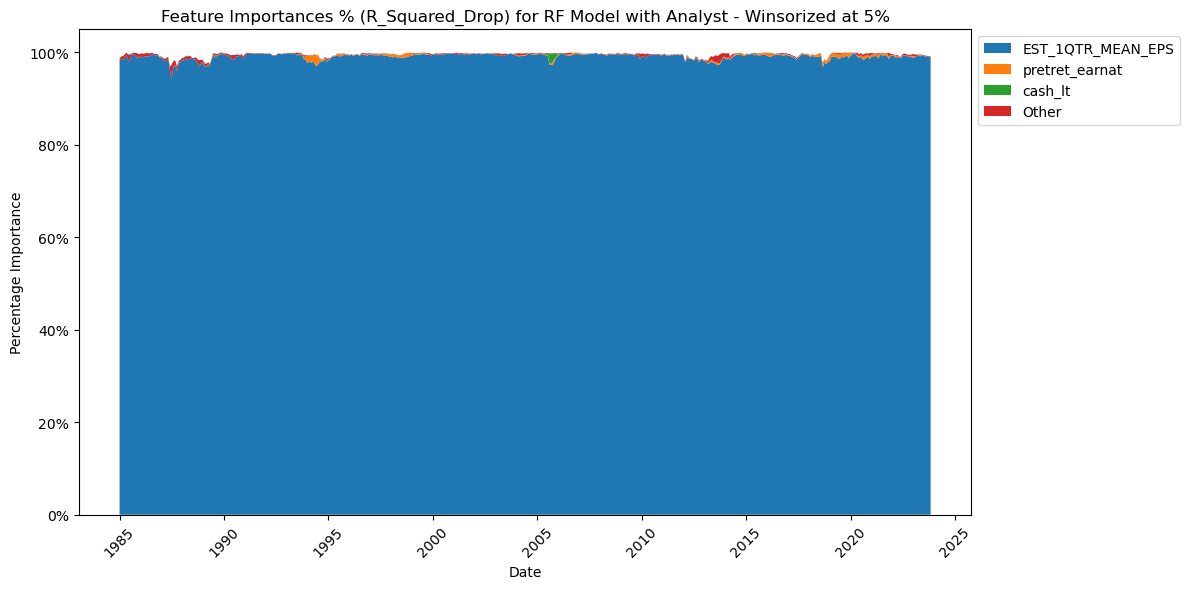

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_RF_Model_with_Analyst_-_Winsorized_at_5perc.png


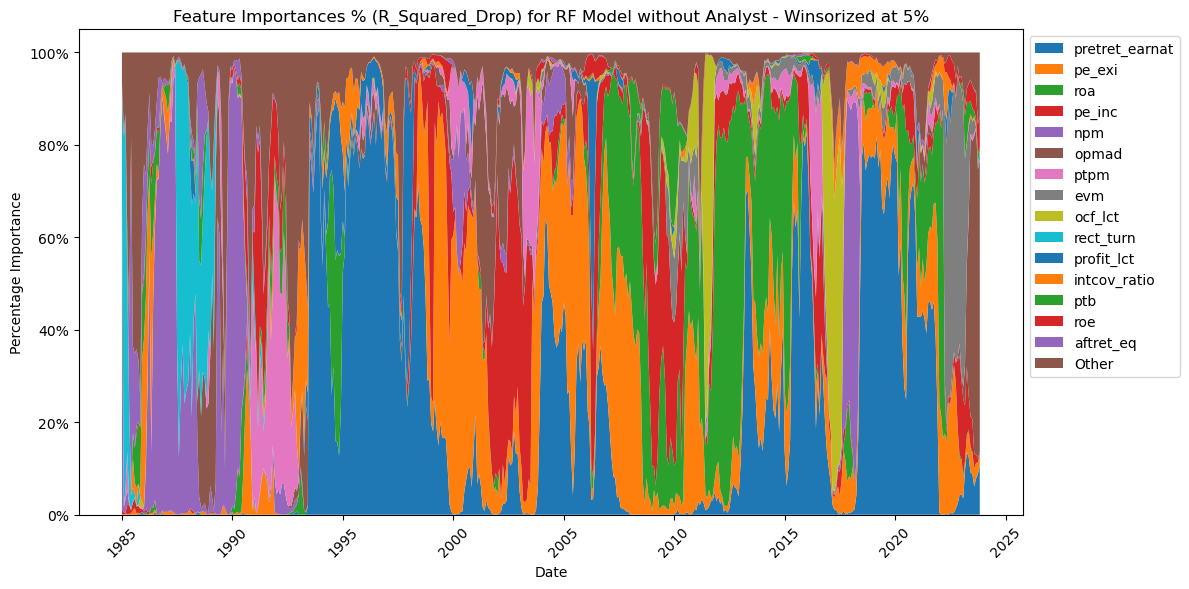

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_RF_Model_without_Analyst_-_Winsorized_at_5perc.png


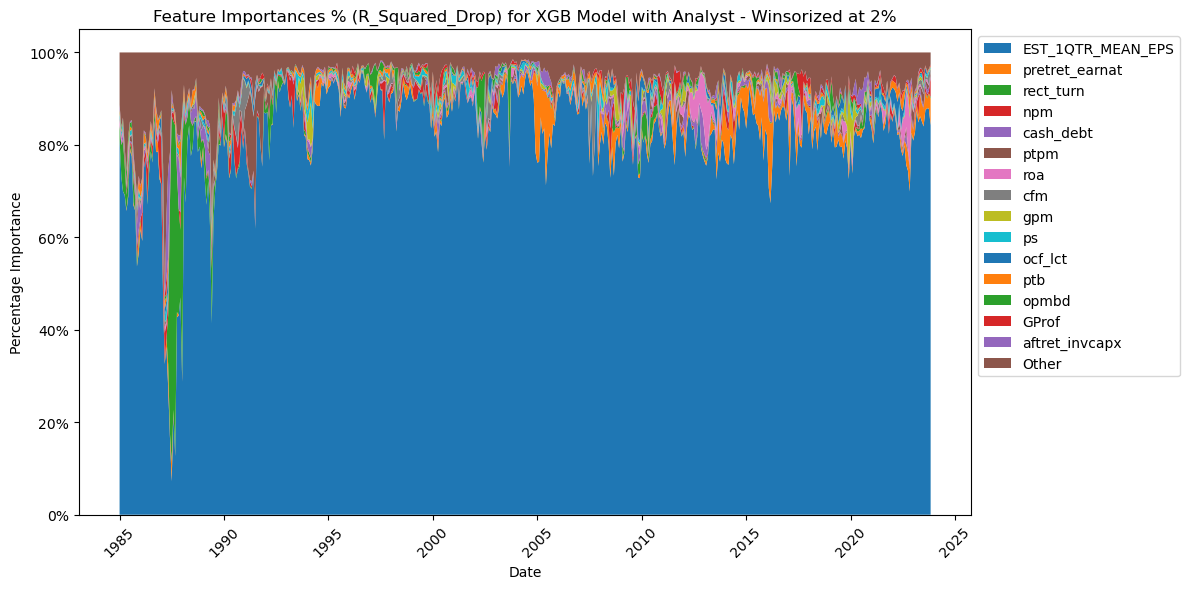

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_XGB_Model_with_Analyst_-_Winsorized_at_2perc.png


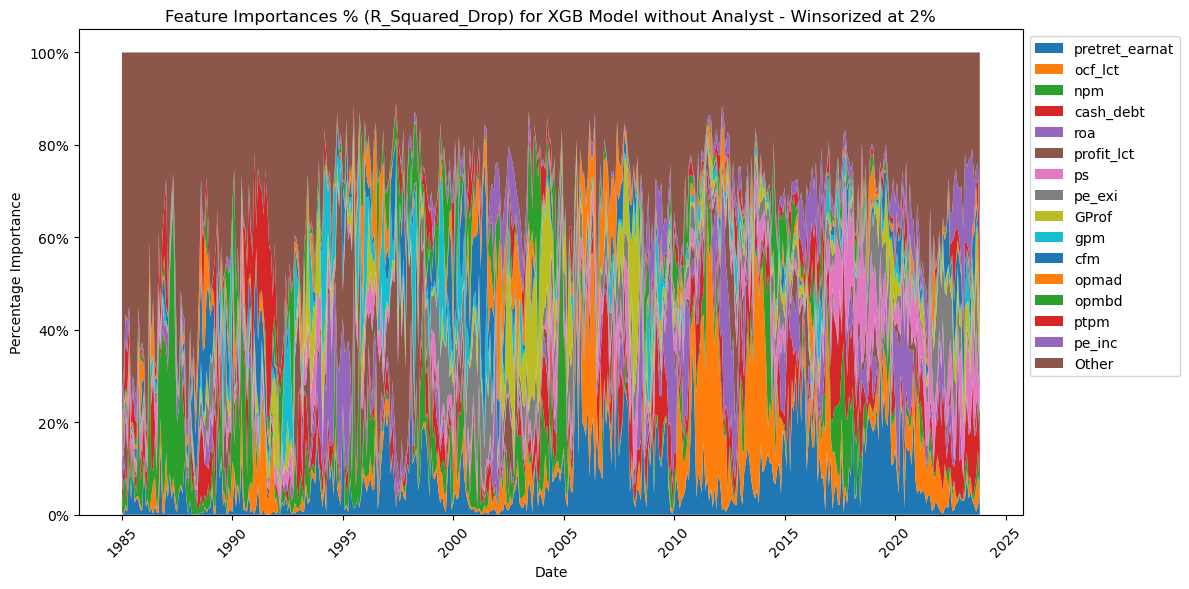

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_XGB_Model_without_Analyst_-_Winsorized_at_2perc.png


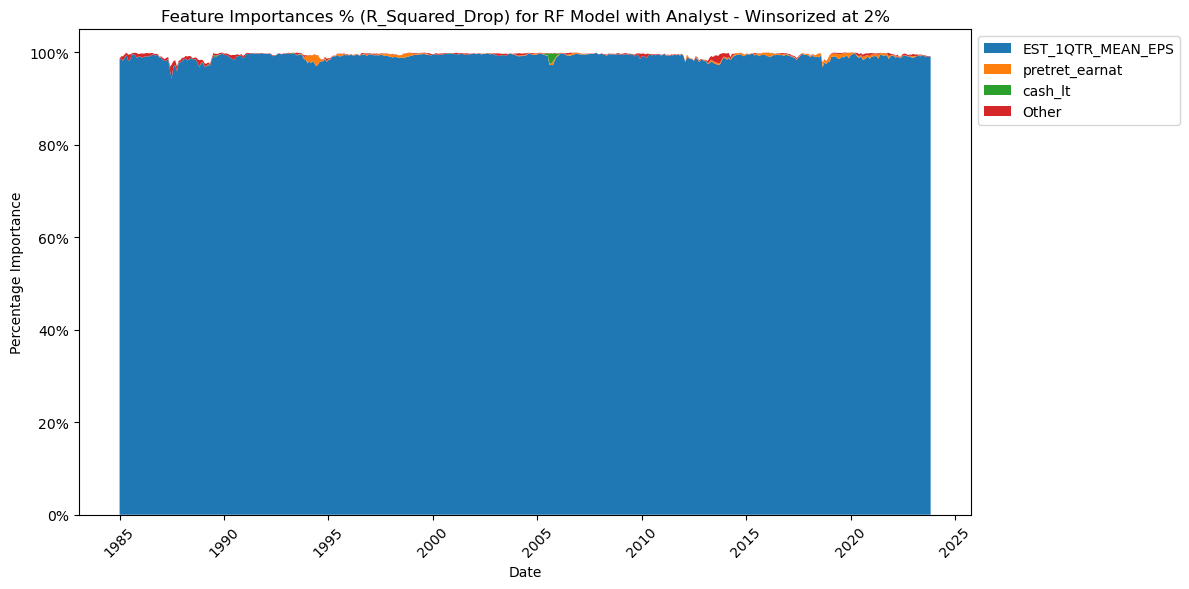

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_RF_Model_with_Analyst_-_Winsorized_at_2perc.png


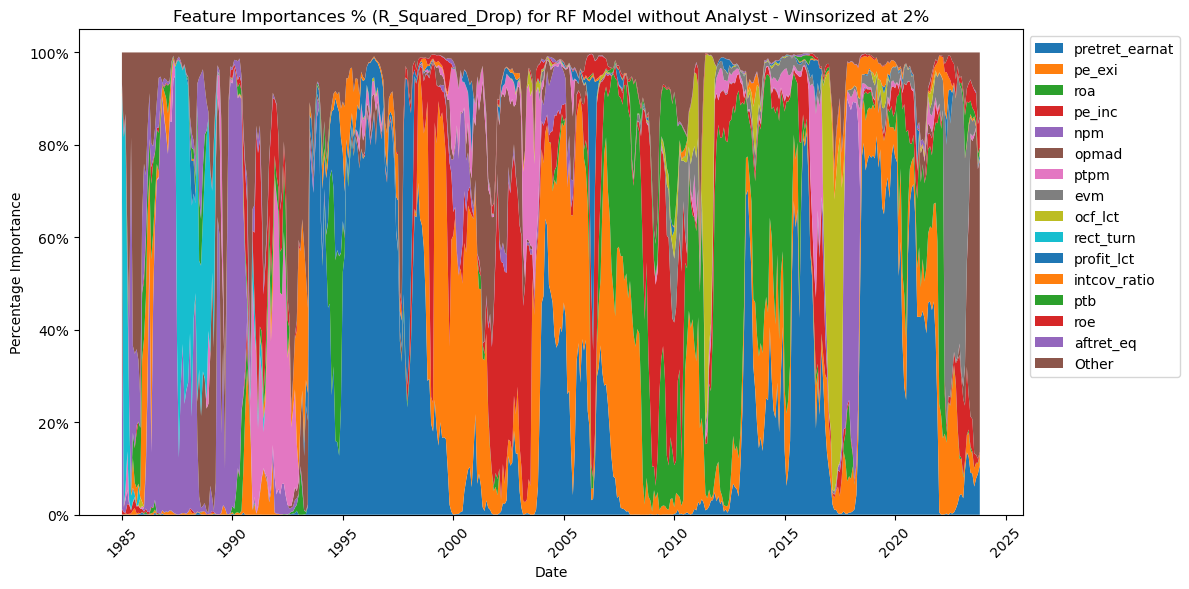

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_for_RF_Model_without_Analyst_-_Winsorized_at_2perc.png


In [133]:
def plot_configurations(config_dfs, output_dir='output_plots', winsorize=None):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create a plot for each configuration
    for (model_type, with_analyst), df in config_dfs.items():
        plt.figure(figsize=(12, 6))

        # Calculate the mean importance over time for each feature
        mean_importances = df.mean(axis=0)
        # Sort features by their average importance and keep only the top 15
        top_features = mean_importances.sort_values(ascending=False).head(15).index.tolist()
        # Identify features not in the top 15 to group as 'Other'
        other_features = [feature for feature in df.columns if feature not in top_features]

        # Aggregate other features into a single series
        if other_features:
            df['Other'] = df[other_features].sum(axis=1)
            df.drop(columns=other_features, inplace=True)

        # Reorder dataframe to plot top 1 feature, next 14 features, then 'Other'
        ordered_features = [top_features[0]] + top_features[1:15] + ['Other'] if 'Other' in df.columns else top_features[0:15]

        # Only keep features with a maximum percentage over a certain threshold (e.g., 2%)
        df = df.loc[:, df.max() > 2]

        # Stack plot with labels for ordered features
        plt.stackplot(df.index, [df[feature] for feature in ordered_features if feature in df.columns], labels=[feature for feature in ordered_features if feature in df.columns])
        winz_title = f" - Winsorized at {winsorize}" if winsorize else ""
        title = f'Feature Importances % (R_Squared_Drop) for {model_type.upper()} Model {"with" if with_analyst == "yes" else "without"} Analyst{winz_title}'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Percentage Importance')
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y / 100)))  # Adjust based on how data is scaled
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Generate filename from title
        filename = f"{title.replace(' ', '_').replace('%', 'perc')}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        plt.show()
        print(f"Plot saved as {filename}")

# Example usage, ensure that config_d
plot_configurations(config_dfs_R_5, winsorize='5%')
plot_configurations(config_dfs_R_2, winsorize='2%')

In [134]:
# Example usage, assuming `metrics_df` is your DataFrame
config_dfs_2 = get_feature_importances_by_configuration(metrics_02)
config_dfs_5 = get_feature_importances_by_configuration(metrics_02)


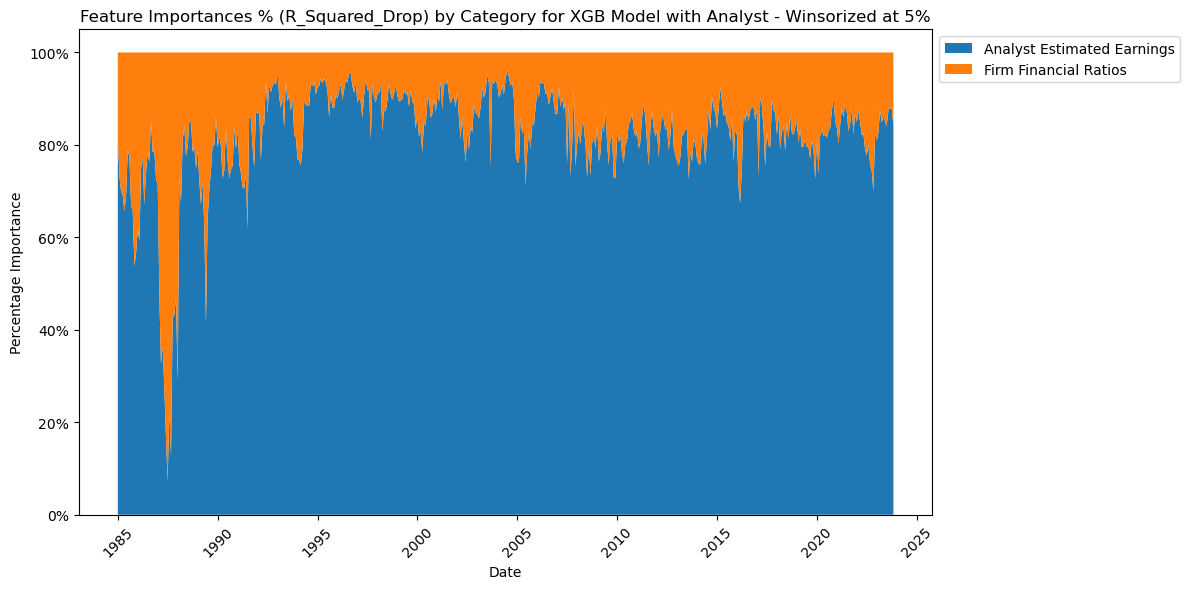

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_XGB_Model_with_Analyst_-_Winsorized_at_5perc.png


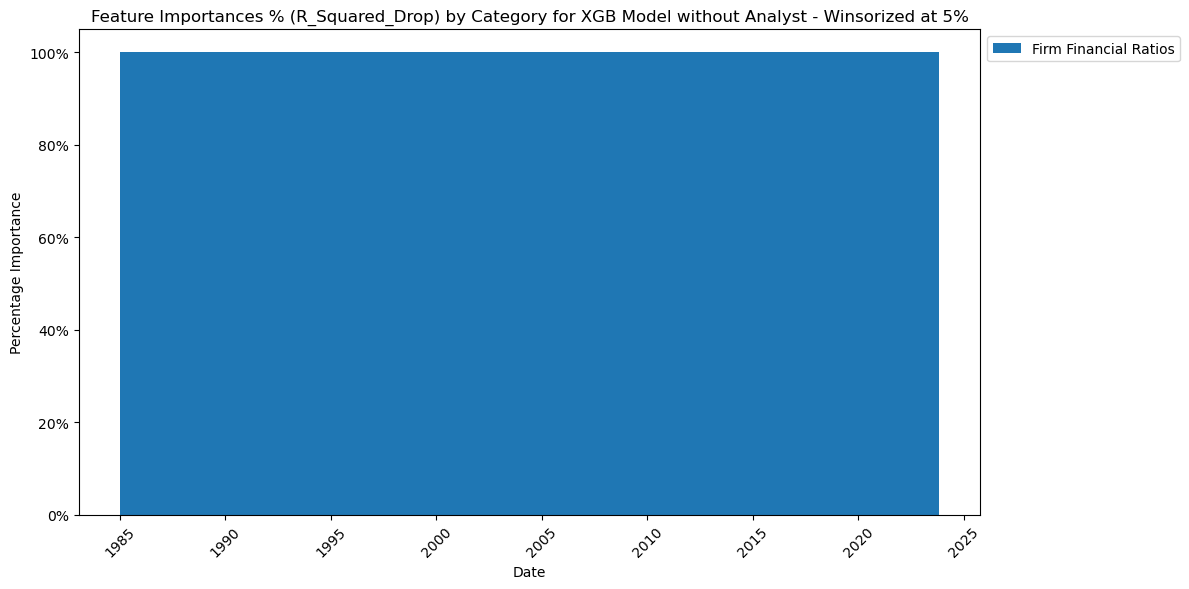

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_XGB_Model_without_Analyst_-_Winsorized_at_5perc.png


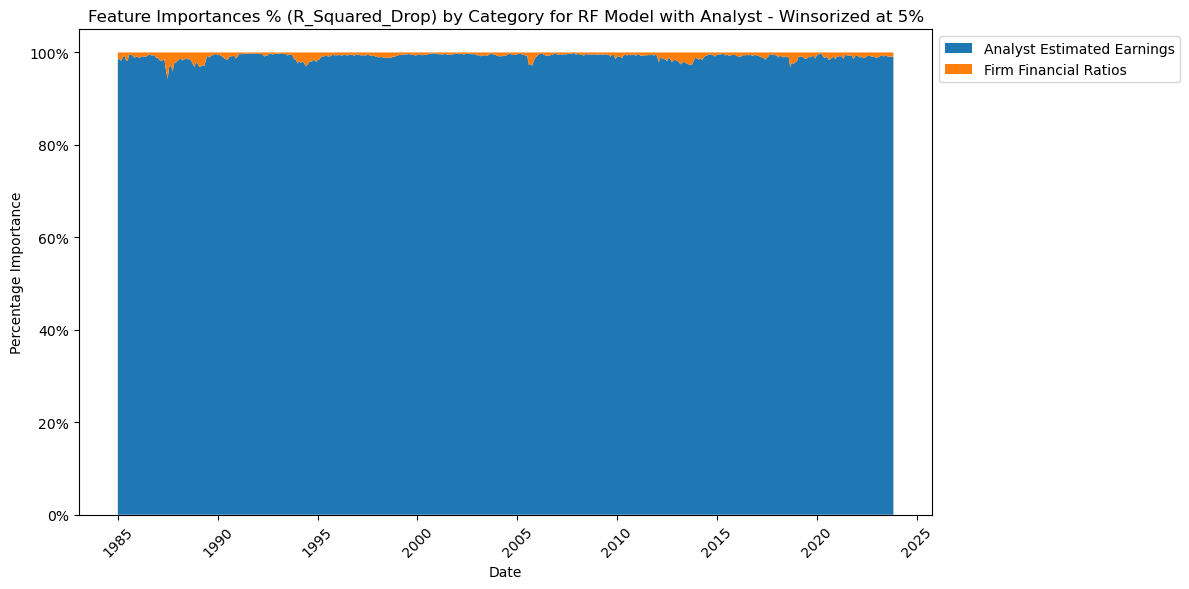

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_RF_Model_with_Analyst_-_Winsorized_at_5perc.png


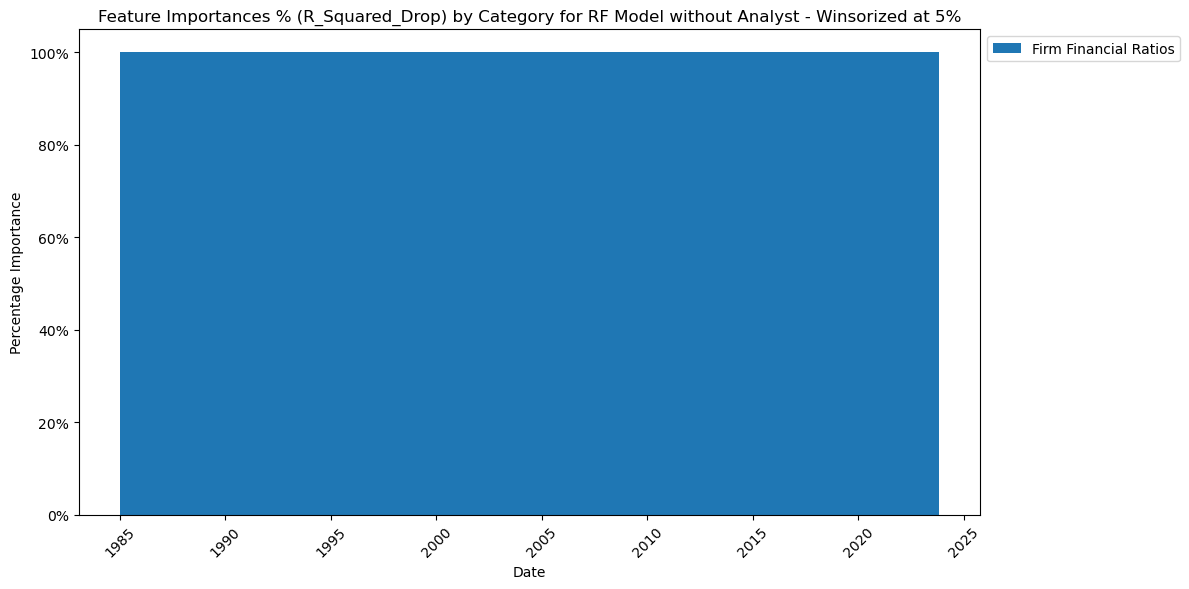

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_RF_Model_without_Analyst_-_Winsorized_at_5perc.png


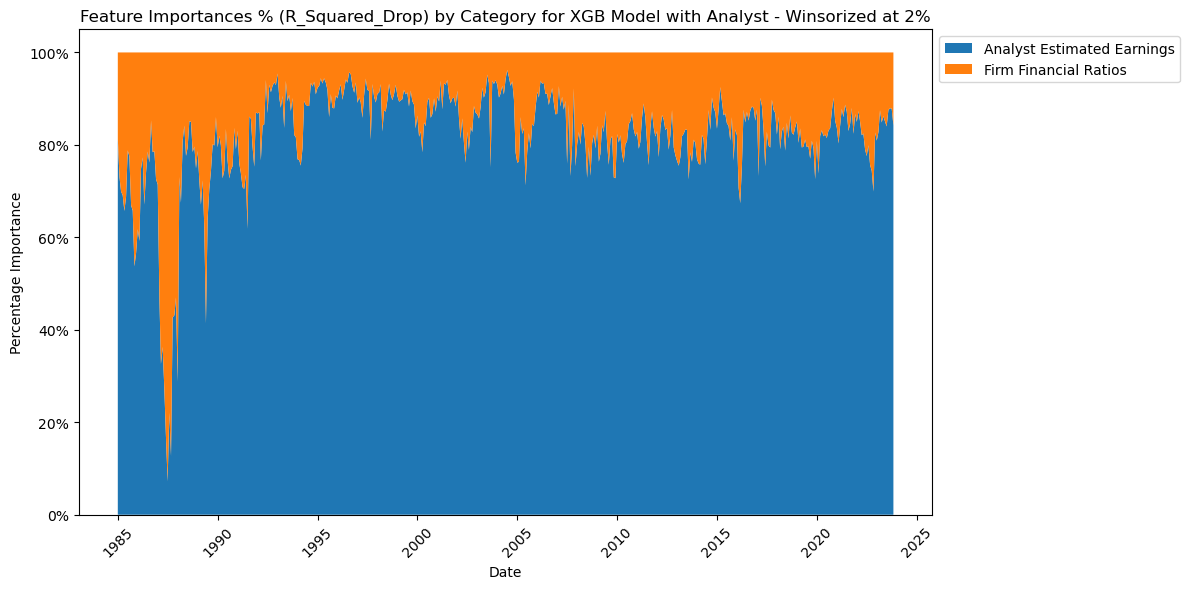

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_XGB_Model_with_Analyst_-_Winsorized_at_2perc.png


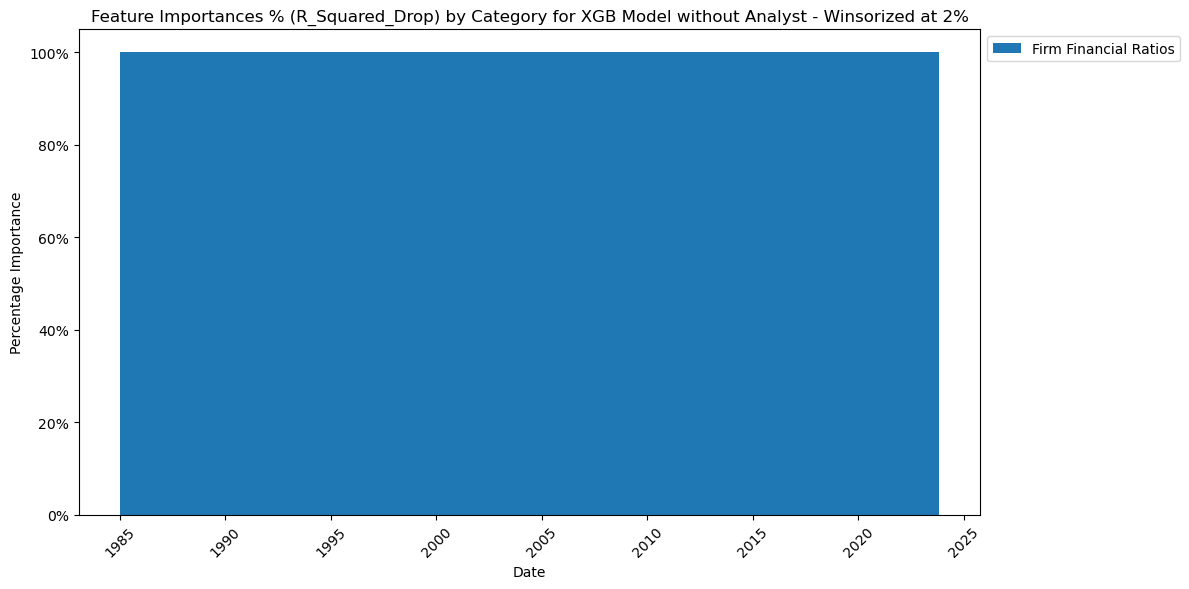

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_XGB_Model_without_Analyst_-_Winsorized_at_2perc.png


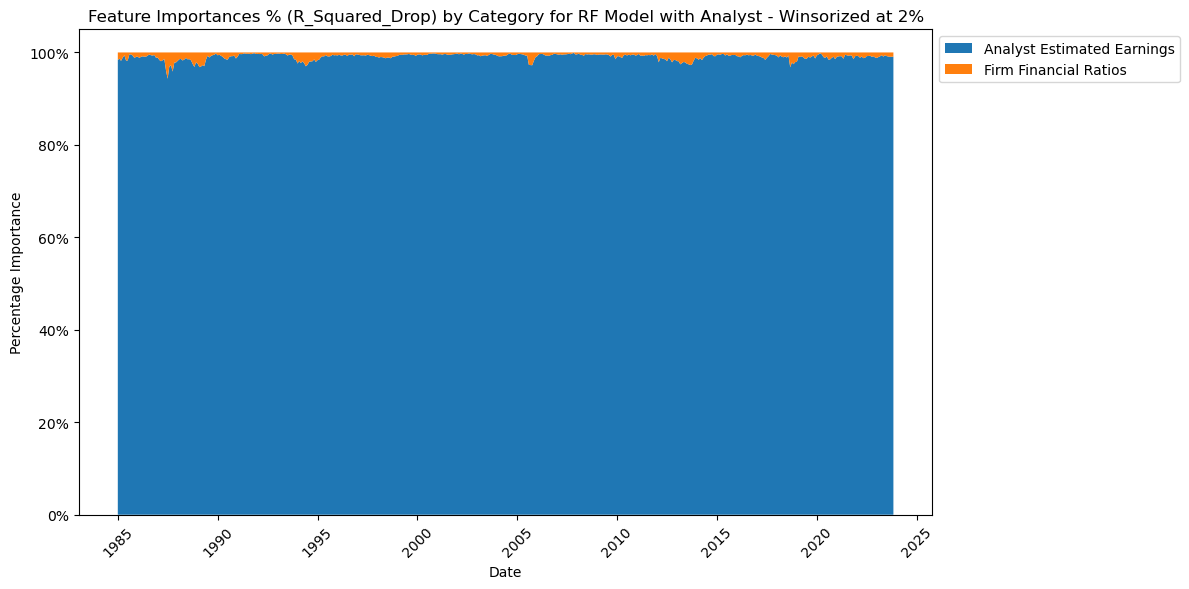

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_RF_Model_with_Analyst_-_Winsorized_at_2perc.png


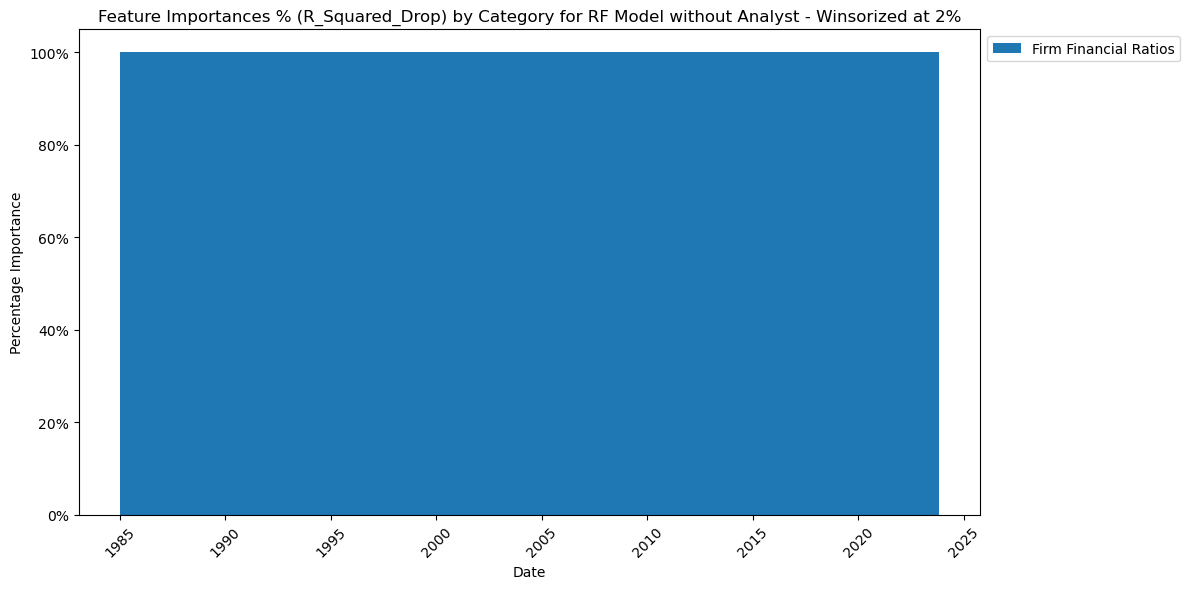

Plot saved as Feature_Importances_perc_(R_Squared_Drop)_by_Category_for_RF_Model_without_Analyst_-_Winsorized_at_2perc.png


In [135]:
def plot_configurations(config_dfs, output_dir='output_plots', winsorize=None):
    # Define the group mappings
    group_mappings = {
        'log_diff_ROUTPUT': 'Economic Data',
        'log_diff_RCON': 'Economic Data',
        'log_diff_IPT': 'Economic Data',
        'UNEMPLOYMENT': 'Economic Data',
        'EST_1QTR_MEAN_EPS': 'Analyst Estimated Earnings',
    }

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Create a plot for each configuration
    for (model_type, with_analyst), df in config_dfs.items():
        plt.figure(figsize=(12, 6))

        # Initialize a DataFrame for grouped data
        grouped_df = pd.DataFrame(index=df.index)

        # Aggregate features according to the group mappings
        for feature in df.columns:
            group_name = group_mappings.get(feature, 'Firm Financial Ratios')
            if group_name not in grouped_df:
                grouped_df[group_name] = df[feature]
            else:
                grouped_df[group_name] += df[feature]

        # Only keep groups with a maximum percentage over a certain threshold (e.g., 2%)
        grouped_df = grouped_df.loc[:, grouped_df.max() > 2]

        # Plotting the stack plot
        plt.stackplot(grouped_df.index, [grouped_df[group] for group in grouped_df.columns], labels=grouped_df.columns)

        # Construct the title to include Winsorization if specified
        winz_title = f" - Winsorized at {winsorize}" if winsorize else ""
        title = f'Feature Importances % (R_Squared_Drop) by Category for {model_type.upper()} Model {"with" if with_analyst == "yes" else "without"} Analyst{winz_title}'
        plt.title(title)
        plt.xlabel('Date')
        plt.ylabel('Percentage Importance')
        # Format y-axis as percentages
        plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y/100)))
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xticks(rotation=45)
        plt.tight_layout()

        # Generate filename from title, include Winsorization info
        filename = f"{title.replace(' ', '_').replace('%', 'perc')}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        plt.show()
        print(f"Plot saved as {filename}")

# Example usage, make sure config_dfs is correctly defined:
plot_configurations(config_dfs_R_5, winsorize='5%')
plot_configurations(config_dfs_R_2, winsorize='2%')


In [142]:
overall_mean_5_R, crises_mean_5_R = calculate_top_features_over_time(config_dfs_5)
overall_mean_2_R, crises_mean_2_R = calculate_top_features_over_time(config_dfs_2)



In [144]:
# Convert Series to DataFrames with a clear label for merging
df_overall_mean_5 = overall_mean_5_R.reset_index()
df_overall_mean_5.columns = ['Feature', 'Overall_Importance_5']

df_crises_mean_5 = crises_mean_5_R.reset_index()
df_crises_mean_5.columns = ['Feature', 'Crises_Importance_5']

df_overall_mean_2 = overall_mean_2_R.reset_index()
df_overall_mean_2.columns = ['Feature', 'Overall_Importance_2']

df_crises_mean_2 = crises_mean_2_R.reset_index()
df_crises_mean_2.columns = ['Feature', 'Crises_Importance_2']

dfs = [df_overall_mean_5, df_crises_mean_5, df_overall_mean_2, df_crises_mean_2]
df_final = reduce(lambda left, right: pd.merge(left, right, on='Feature', how='outer'), dfs)

# Save to CSV
df_final.to_csv('top_features_by_Rsquared.csv', index=False)

In [137]:
display(overall_mean_5_R)
display(crises_mean_5_R)

EST_1QTR_MEAN_EPS    20.251656
pretret_earnat        8.692678
roa                   6.485827
opmad                 5.106330
ptpm                  4.290915
profit_lct            4.108474
npm                   3.894392
pe_exi                3.065851
pe_inc                2.617327
evm                   2.437032
ocf_lct               2.367958
intcov_ratio          2.302413
roce                  2.241527
roe                   1.974781
opmbd                 1.816597
dtype: float64

EST_1QTR_MEAN_EPS    20.888349
roa                   9.830702
pretret_earnat        8.689864
opmad                 6.452653
profit_lct            5.172761
ptpm                  4.115050
npm                   3.541476
evm                   3.182200
pe_inc                3.161797
pe_exi                3.158280
cfm                   2.914384
opmbd                 2.412973
roce                  2.023418
roe                   1.680929
pcf                   1.519099
dtype: float64

In [138]:
display(overall_mean_2_R)
display(crises_mean_2_R)

EST_1QTR_MEAN_EPS    20.251656
pretret_earnat        8.692678
roa                   6.485827
opmad                 5.106330
ptpm                  4.290915
profit_lct            4.108474
npm                   3.894392
pe_exi                3.065851
pe_inc                2.617327
evm                   2.437032
ocf_lct               2.367958
intcov_ratio          2.302413
roce                  2.241527
roe                   1.974781
opmbd                 1.816597
dtype: float64

EST_1QTR_MEAN_EPS    20.888349
roa                   9.830702
pretret_earnat        8.689864
opmad                 6.452653
profit_lct            5.172761
ptpm                  4.115050
npm                   3.541476
evm                   3.182200
pe_inc                3.161797
pe_exi                3.158280
cfm                   2.914384
opmbd                 2.412973
roce                  2.023418
roe                   1.680929
pcf                   1.519099
dtype: float64

### Plotting the earning surprise

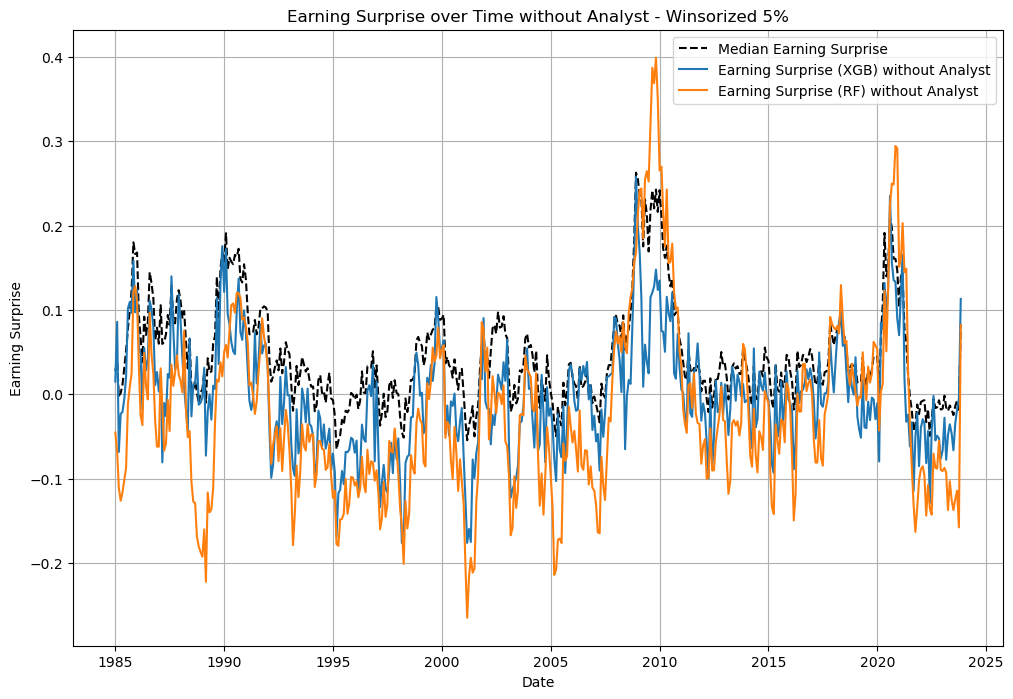

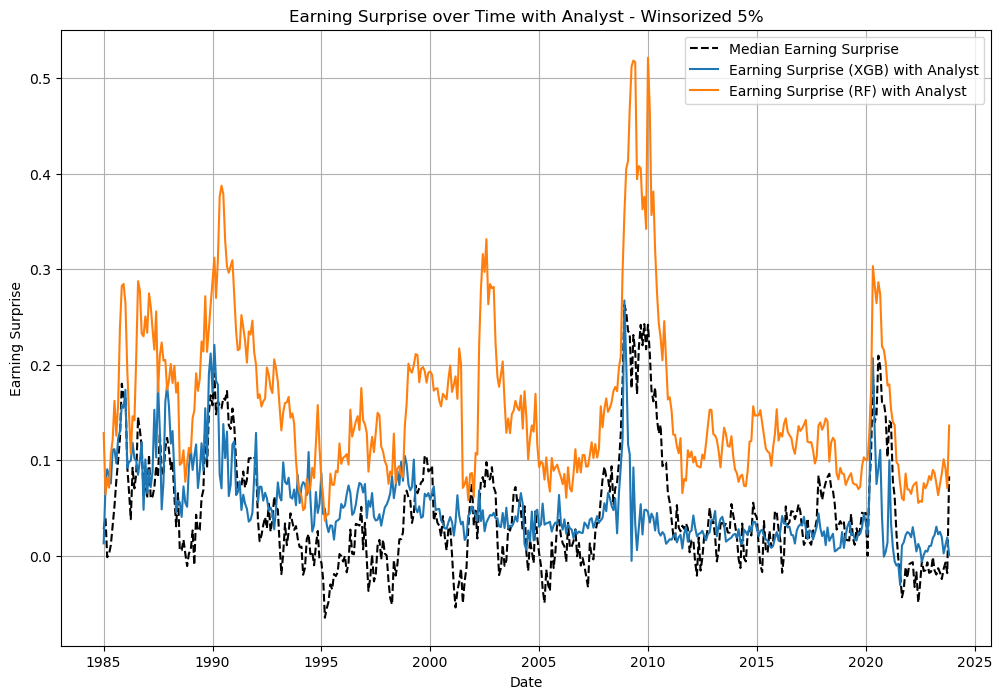

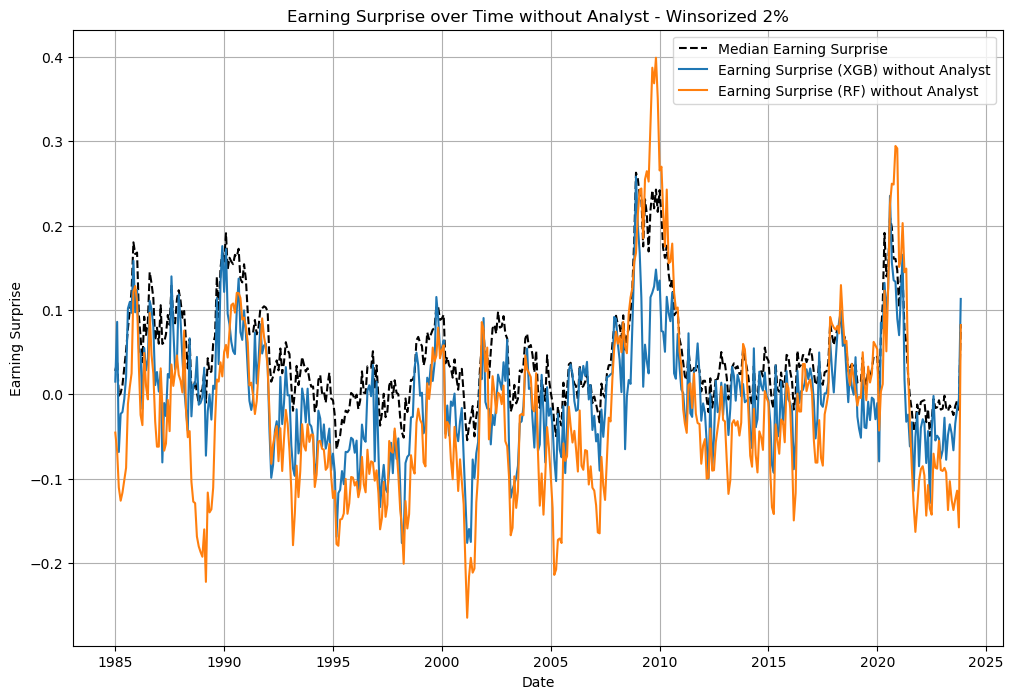

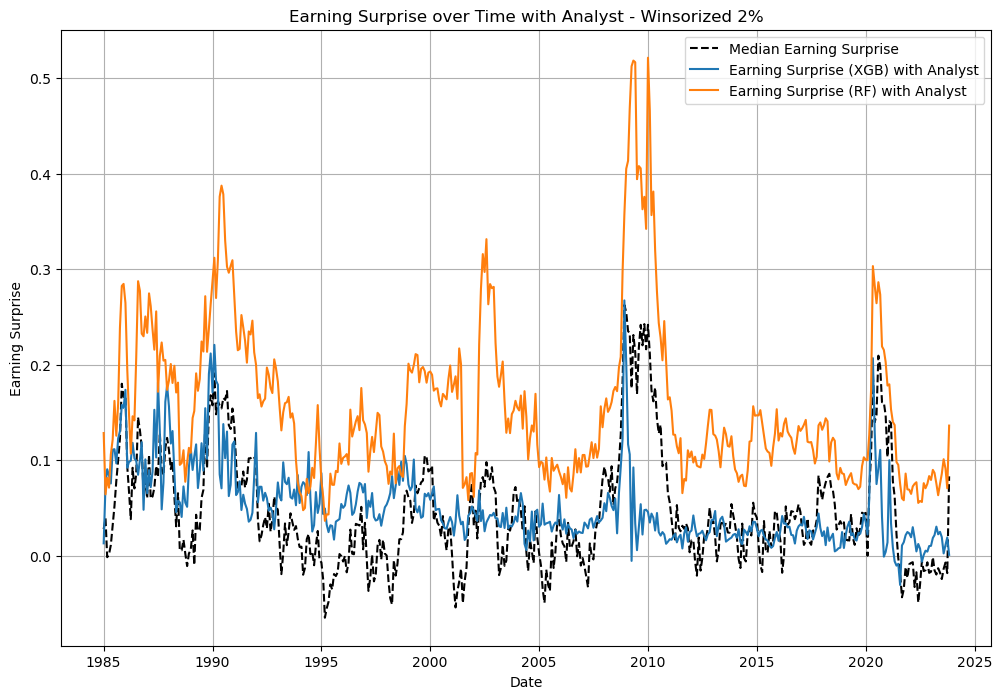

In [139]:
def plot_earning_surprise(df, output_dir='output_plots', analyst_incld='yes', winzorize=None):
    # Ensure 'date' column is in datetime format
    df['date'] = pd.to_datetime(df['date'])

    # Drop duplicates by aggregating median_earning_surprise by date
    df_median = df.groupby('date')['median_earning_surprise'].mean().reset_index()

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot aggregated median_earning_surprise
    ax.plot(df_median['date'], df_median['median_earning_surprise'], label='Median Earning Surprise', linestyle='--', color='black')
    
    # Set models to plot
    models = ['xgb', 'rf']

    # Plot Earning Surprise for each model type where analyst inclusion matches the function parameter
    for model in models:
        subset = df[(df['model_type'] == model) & (df['with_analyst'] == analyst_incld)]
        label = f'Earning Surprise ({model.upper()}) with Analyst' if analyst_incld == 'yes' else f'Earning Surprise ({model.upper()}) without Analyst'
        ax.plot(subset['date'], subset['Earning_Surprise_Model'], label=label)

    # Dynamic labels and title based on analyst inclusion and Winsorization
    winz_suffix = f" - Winsorized {winzorize}" if winzorize else ""
    title_suffix = "with Analyst" if analyst_incld == 'yes' else "without Analyst"
    ax.set_title(f'Earning Surprise over Time {title_suffix}{winz_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Earning Surprise')

    # Add legend and grid
    ax.legend()
    ax.grid(True)
    
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save plot with dynamic filename based on analyst inclusion and Winsorization
    filename = f'Earning_Surprise_{title_suffix.replace(" ", "_")}{winz_suffix.replace(" ", "_").replace("-", "")}.png'
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)
    
    # Show plot
    plt.show()


plot_earning_surprise(metrics_05, analyst_incld='no', winzorize='5%')
plot_earning_surprise(metrics_05, analyst_incld='yes', winzorize='5%')

plot_earning_surprise(metrics_02, analyst_incld='no', winzorize='2%')
plot_earning_surprise(metrics_02, analyst_incld='yes', winzorize='2%')
